 # Obligatorio Análisis de Series Temporales

## Carga de bibliotecas

In [1]:
#install.packages("quantmod")
#install.packages("tidyquant")
#install.packages("prophet")
#install.packages("TSstudio")
#install.packages("PerformanceAnalytics")




library(astsa)
library(lubridate)
library(xts)
library(keras) # for deep learning
library(tidyquant)
library(quantmod)



options(repr.plot.width=12, repr.plot.height=7) #ajusta tamaño de graficas



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: PerformanceAnalytics


Attaching package: 'PerformanceAnalytics'


The following object is masked from 'package:graphics':

    legend


Loading required package: quantmod

Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

== Need to Learn tidyquant? ==========================================================================================
Business Science offers a 1-hour course - Learning Lab #9: Performance Analysis & Portfolio Optimization with tidyquant!
</> Learn more at: https://university.business-science.io/p/learning-labs-pro </>



In [2]:
## Lectura de Acciones

In [103]:
portfolio_raw <- c("BTC-USD","ETH-USD","TSLA","AAPL","USDT-USD","BNB-USD","^GSPC")
getSymbols(portfolio_raw, src="yahoo", from="2017-07-15")


Warning message:
"BTC-USD contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."
Warning message:
"ETH-USD contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."
Warning message:
"USDT-USD contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."
pausing 1 second between requests for more than 5 symbols

Warning message:
"BNB-USD contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."
pausing 1 second between requests for mo

[1] "BTC-USD"  "ETH-USD"  "TSLA"     "AAPL"     "USDT-USD" "BNB-USD"  "^GSPC"

### Cambio de nombre a series y columnas

In [104]:
btc <- na.omit(`BTC-USD`)
eth <- na.omit(`ETH-USD`)
tsla <- na.omit(TSLA)
aapl <- na.omit(AAPL)
usdt <- na.omit(`USDT-USD`)
bnb  <- na.omit(`BNB-USD`)
sp500 <- na.omit(GSPC)

In [105]:
v_colnames <- c('open','high','low','close','volume','adjusted')

colnames(btc)   <- v_colnames
colnames(eth)   <- v_colnames
colnames(tsla)  <- v_colnames
colnames(aapl)  <- v_colnames
colnames(usdt)  <- v_colnames
colnames(bnb)   <- v_colnames
colnames(sp500) <- v_colnames

btc   <- btc$adjusted
eth   <- eth$adjusted
tsla  <- tsla$adjusted
aapl  <- aapl$adjusted
usdt  <- usdt$adjusted
bnb   <- bnb$adjusted
sp500 <- sp500$adjusted


# Análisis exploratorio inicial

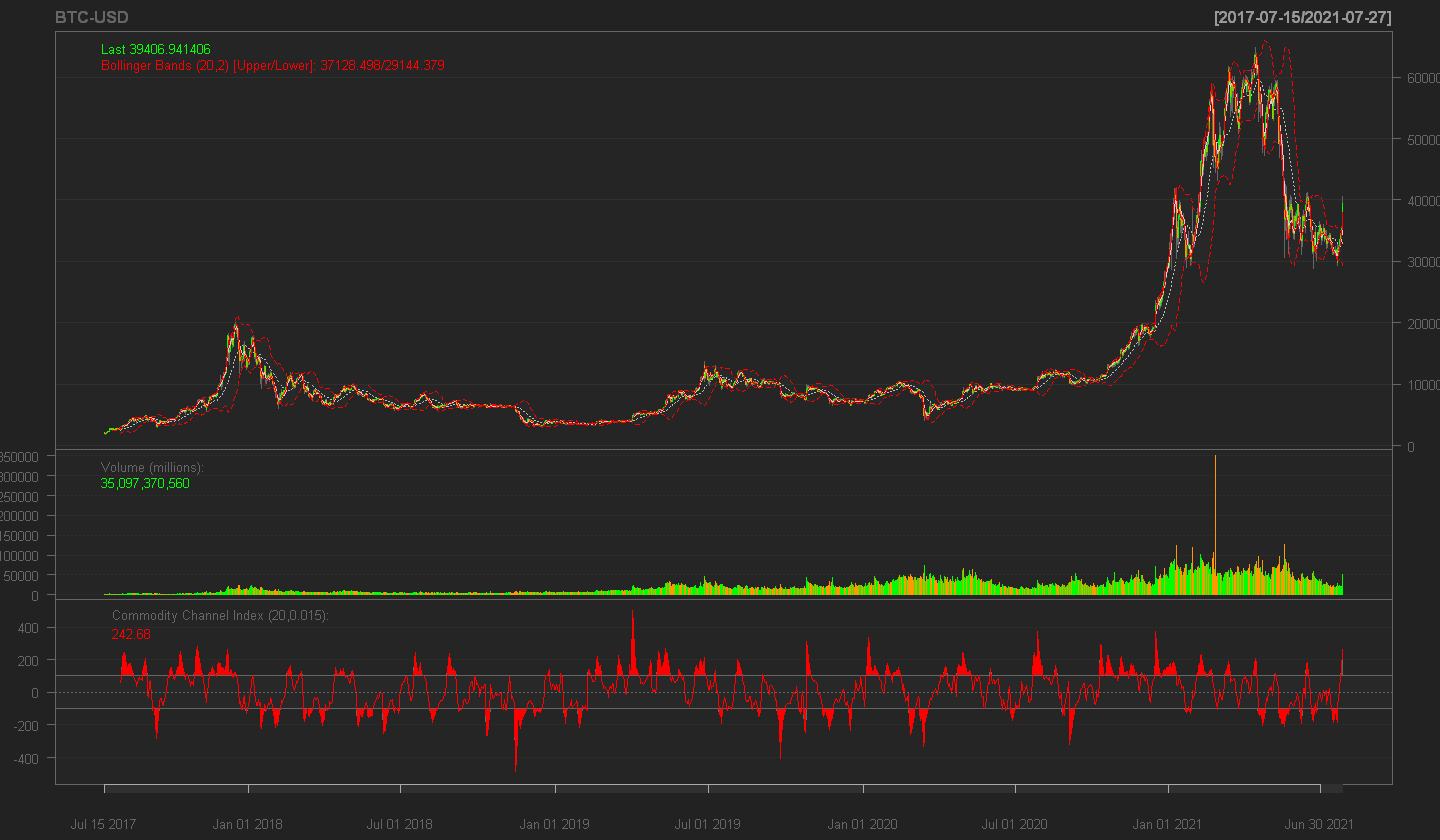

In [106]:
chartSeries(`BTC-USD`,TA="addVo();addBBands();addCCI();addDEMA();addZLEMA()")
#chartSeries(btc)

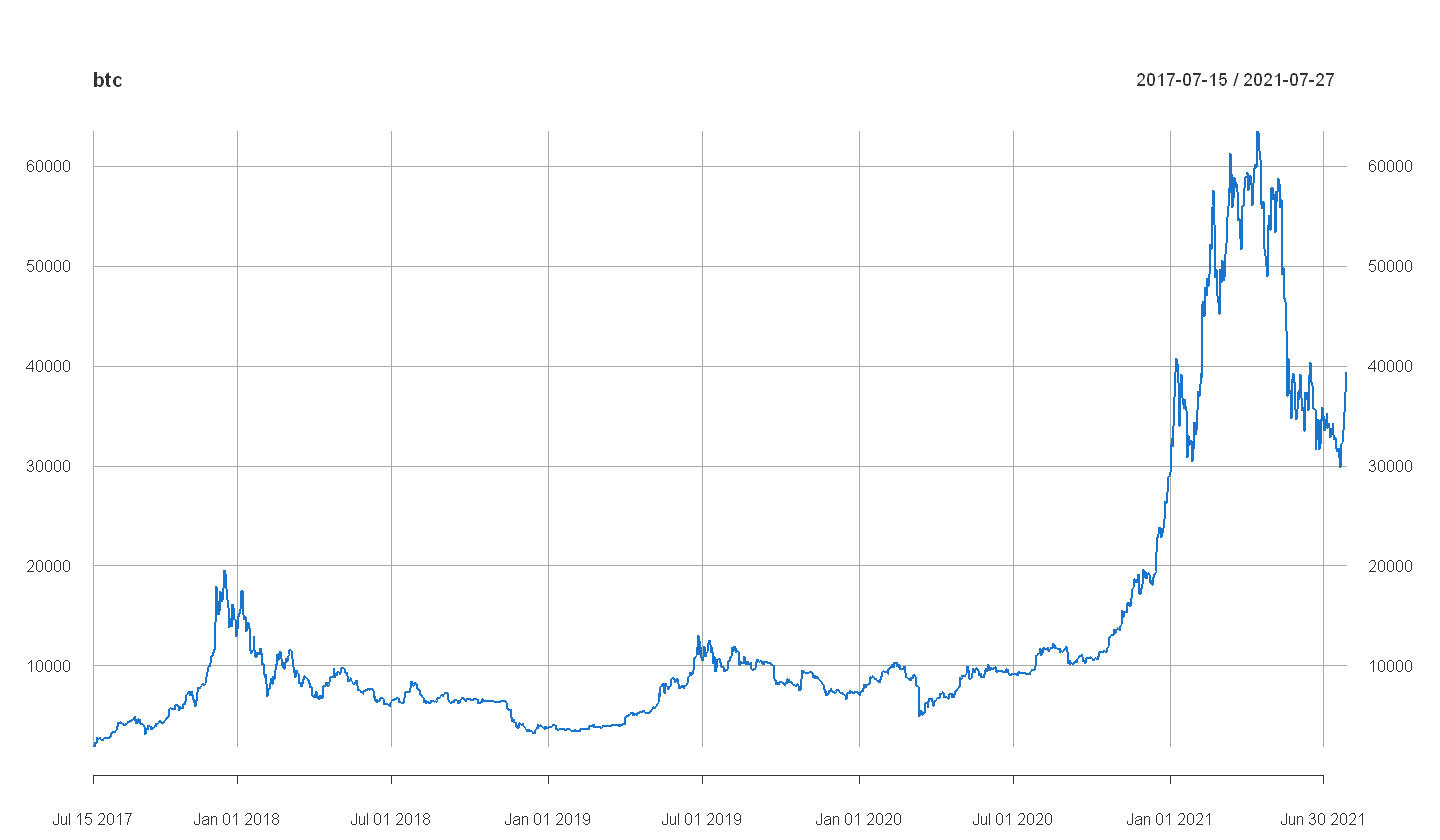

In [107]:
plot(btc, col=4)

La serie tiene un comportamiento hasta 10/20 y luego tiene un comportamiento no estacionario con forma de exponencial. Se prueba a aplicarle la función log a la serie.

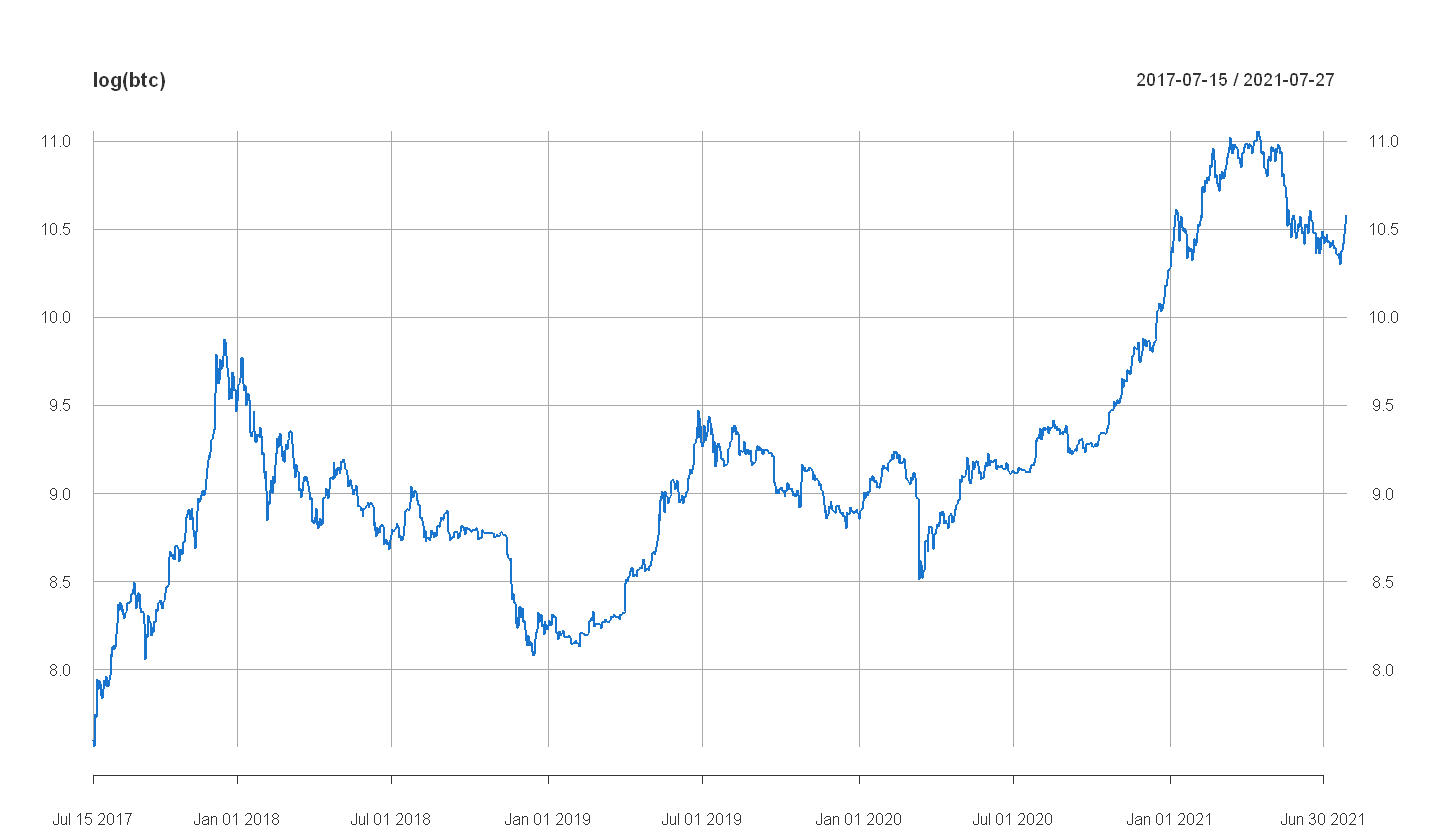

In [108]:
plot(log(btc), col=4)

El log tampoco muestra estacionalidad. En vez de analizar el valor de la función, se va a intentar con la diferencia entre los días (diff). El objetivo es ver si se encuentran patrones en la varianza.

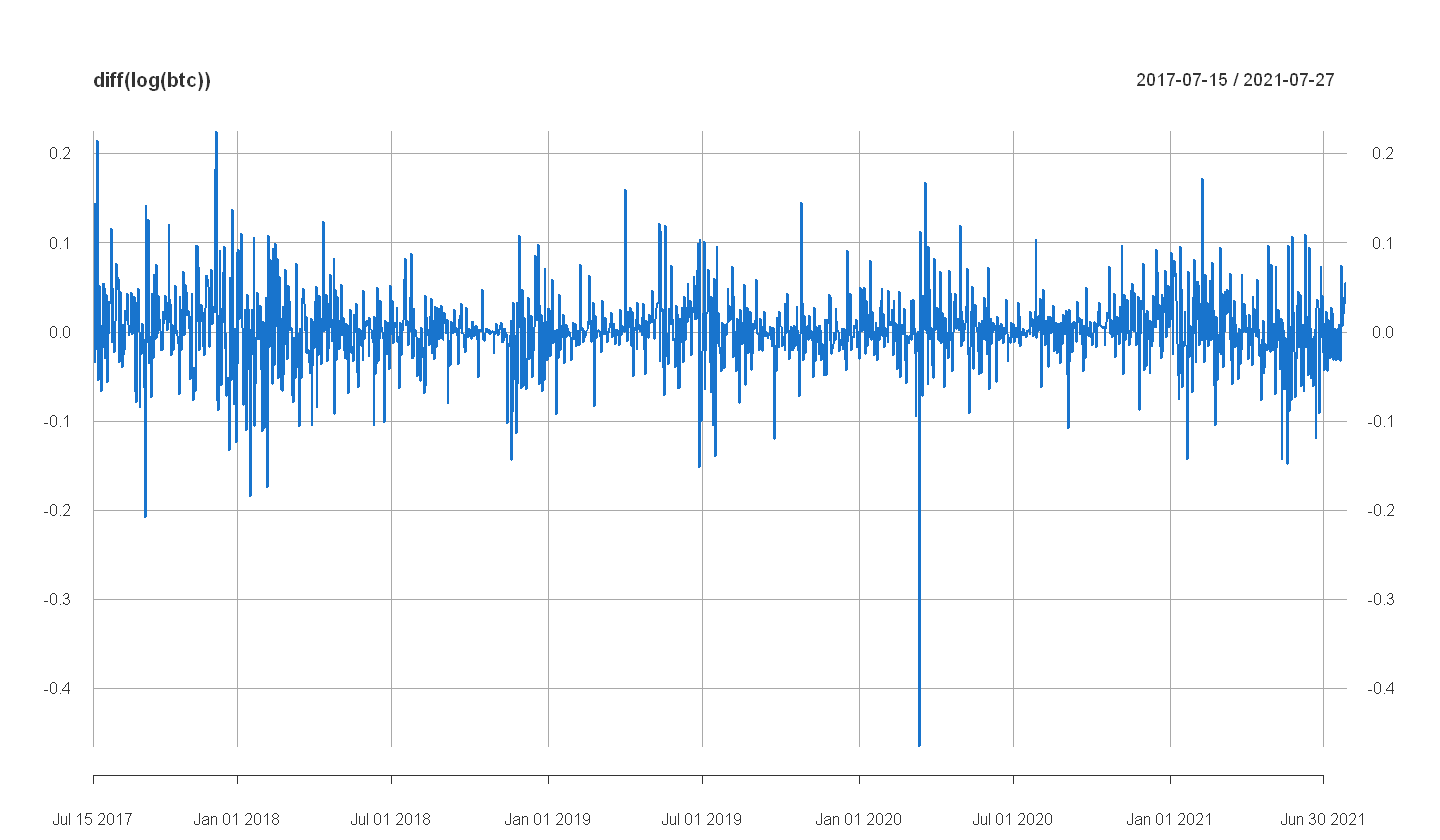

In [109]:
plot(diff(log(btc)), col=4)

La forma ahora de la gráfica tiene un comportamiento que puede llegar a analizarse con técnicas de series.

In [110]:
dlbtc  <- na.omit(diff(log(btc)))
dleth  <- diff(log(eth))
dltsla <- diff(log(tsla))
dlaapl <- diff(log(aapl))


ACF,-0.05,0.05,0.01,0.01,0.03,0.03,-0.02,-0.01,-0.01,0.08,...,0.00,0,0.02,0.04,0.04,-0.01,-0.01,-0.03,0.04,-0.05
PACF,-0.05,0.05,0.02,0.01,0.03,0.04,-0.02,-0.02,-0.01,0.08,...,0.01,0,0.03,0.03,0.04,-0.02,0.00,-0.03,0.03,-0.04


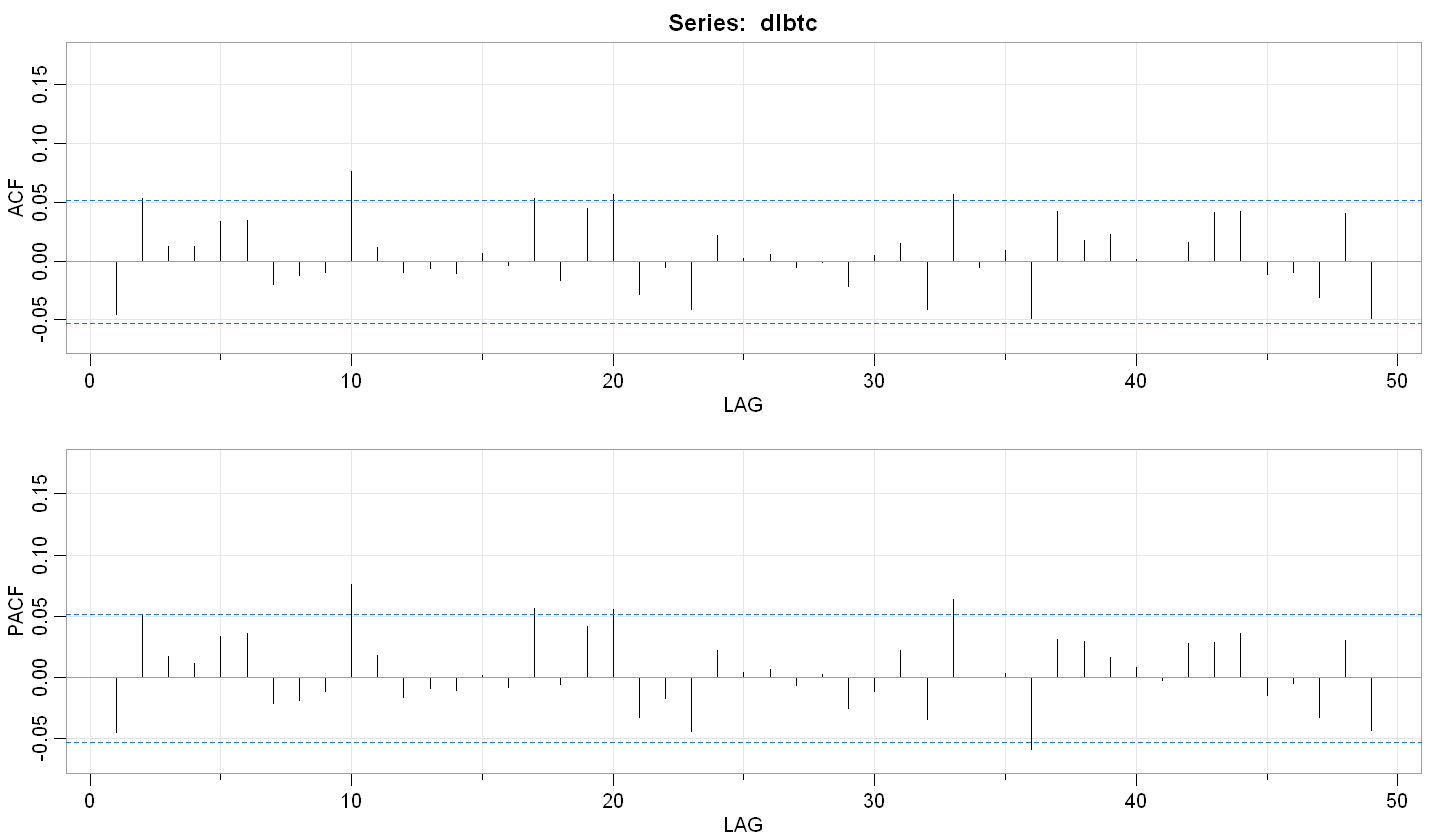

In [111]:
acf2(dlbtc)

ACF,-0.05,0.05,0.01,0.01,0.03,0.03,-0.02,-0.01,-0.01,0.08,...,-0.02,0,0.02,0.02,0.01,0,-0.01,0.05,0.05,-0.02
PACF,-0.05,0.05,0.02,0.01,0.03,0.04,-0.02,-0.02,-0.01,0.08,...,-0.01,0,0.02,0.01,0.01,0,-0.02,0.03,0.05,-0.02


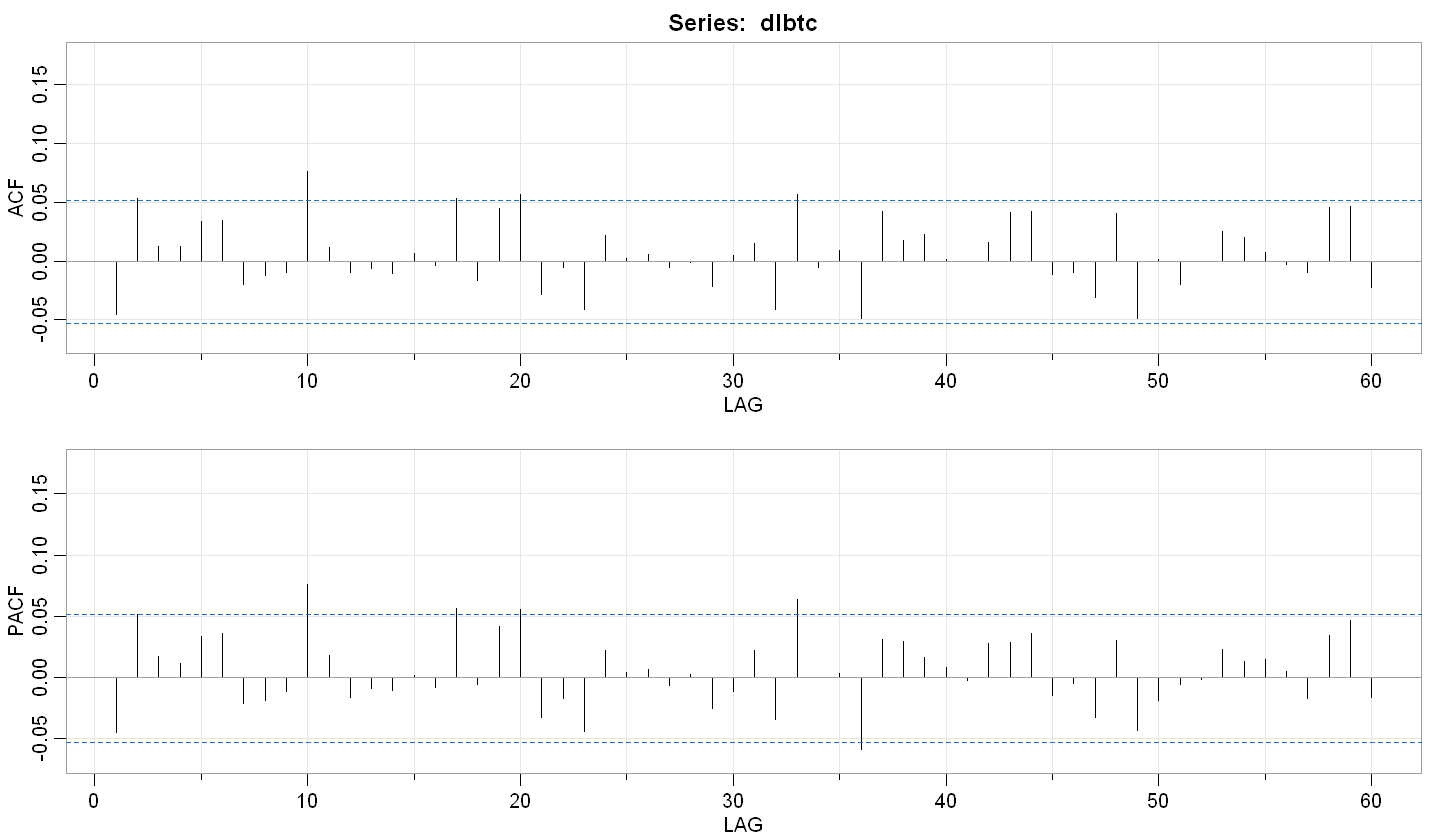

In [112]:
acf2(dlbtc,60)

## Redes Neuronales

###  Definición de funciones

In [113]:
#--------------------------------------------------------------------------
# split_train_test
# Crea los conjuntos train/test de acuerdo a la fecha que se le pasa
#--------------------------------------------------------------------------
split_train_test <- function (x, i_fecha='2021-01-01', i_window=3, i_pred=1) {
    window <- i_window
    pred <-  i_pred
    x_train <- x[time(x)<i_fecha]

    n_train <- length(x_train)
    print(n_train)

    X_train <- matrix(,n_train-window-pred+1,window)
    y_train <- matrix(,n_train-window-pred+1,pred)

    for (i in 1:(n_train-window-pred+1)) {
        X_train[i,] <- x_train[i:(i+window-1)]
        y_train[i,] <- x_train[(i+window):(i+window+pred-1)]
    }

    x_test <- x[time(x)>=i_fecha]
    n_test <- length(x_test)

    X_test <- matrix(,n_test-window-pred+1,window)
    y_test <- matrix(,n_test-window-pred+1,pred)

    for (i in 1:(n_test-window-pred+1)) {
        X_test[i,] <- x_test[i:(i+window-1)]
        y_test[i,] <- x_test[(i+window):(i+window+pred-1)]
    }

    X_train <- array(X_train, dim = c(n_train-window-pred+1, window, 1))
    X_test  <- array(X_test,  dim = c(n_test-window-pred+1, window, 1))
    
    return(list('X_train'=X_train,'y_train'=y_train,'X_test'=X_test,'y_test'=y_test))
}






In [114]:
train_nn <- function (i_model, i_loss, i_optimizer, i_metrics, i_epochs, i_split) {
    
#    summary(i_model)
    i_model %>% compile(loss = i_loss, optimizer = i_optimizer, metrics = i_metrics)
    trained_model <- i_model %>% fit(
        x = X_train, # sequence we're using for prediction 
        y = y_train, # sequence we're predicting
        epochs = i_epochs, # how many times we'll look @ the whole dataset
        validation_split = i_split
    ) # how much data to hold out for testing as we go along
    
    return(list('trained_model'=trained_model,'model'=i_model))
    
}

In [115]:
display_results <- function (i_model, i_trained_model) {
    print("Modelo")
    plot(i_trained_model)
    print("Train")    
    y1 <- predict(i_model,X_train)
    tsplot(y_train, col=4, lwd=2)
    lines(y1, col=6, lwd=2)
    
}

In [116]:
calculate_mse <- function(s1, s2) {
    return ( round(mean((s1 - s2)^2)) )
}

### Definición de variables

In [117]:
v_loss      <- 'mse'
v_optimizer <- 'adam'
v_metrics   <- c('mse')
v_epochs    <- 100
v_split     <- 0.2
v_fecha     <- '2021-01-27'
v_window    <- 3

### Preprocesamiento

In [118]:
#x <- diff(log(btc))
x <- btc

In [119]:
x <- na.omit(x)

### NN simple con 3 días de ventana

In [120]:
split_train <- split_train_test(x,i_fecha=v_fecha, i_window=v_window)

[1] 1288


In [121]:
X_train <- split_train$X_train
y_train <- split_train$y_train
X_test  <- split_train$X_test
y_test  <- split_train$y_test

In [122]:
# initialize our model
model1 <- keras_model_sequential()

model1 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 64, activation="relu") %>%
    layer_dense(units = 1)

In [123]:
trained_model <- train_nn(model1, v_loss, v_optimizer, v_metrics, v_epochs, v_split)


In [124]:
model1         <- trained_model$model
trained_model1 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



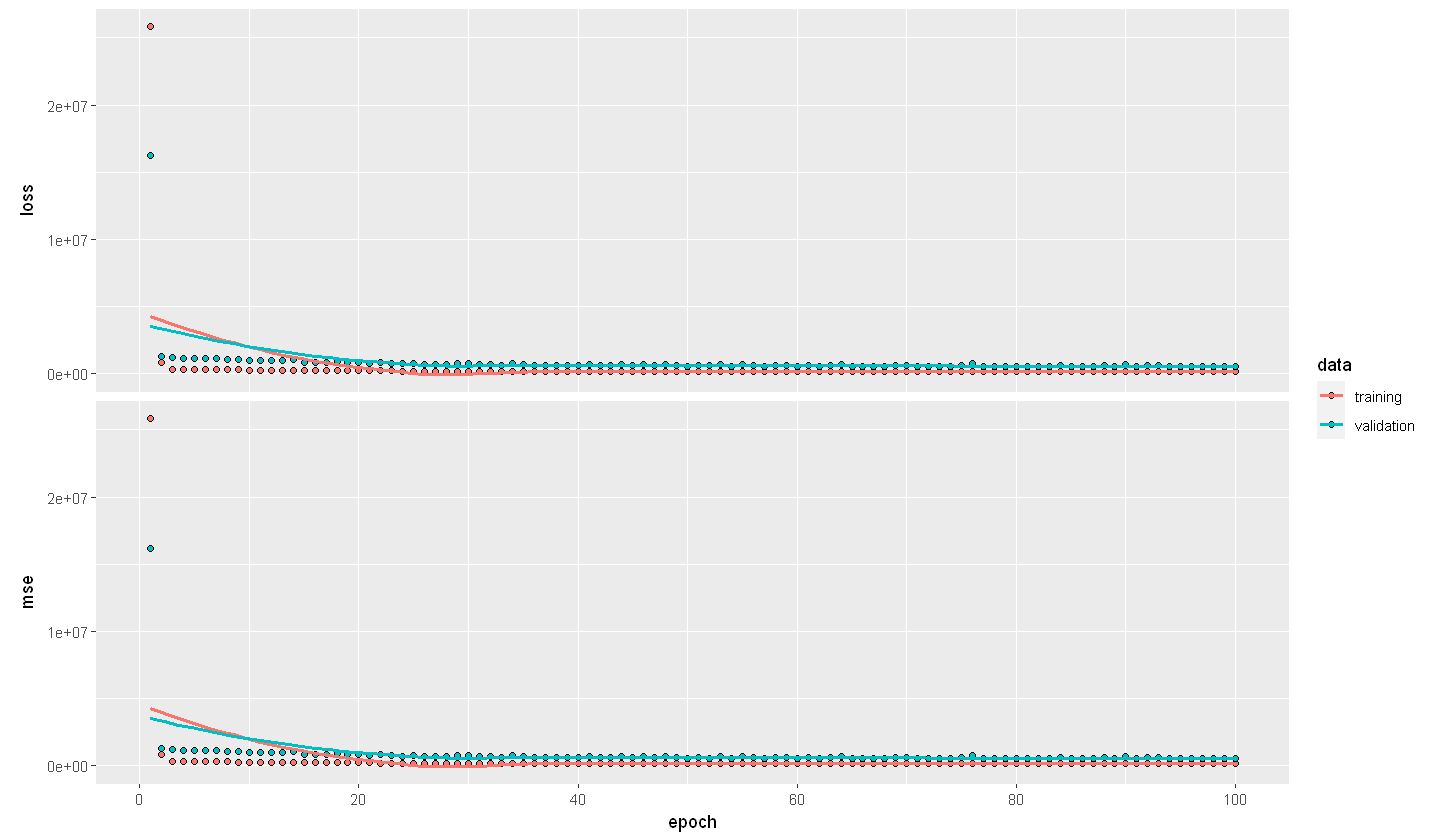

In [125]:
plot(trained_model1)

#### Gráficos de Train

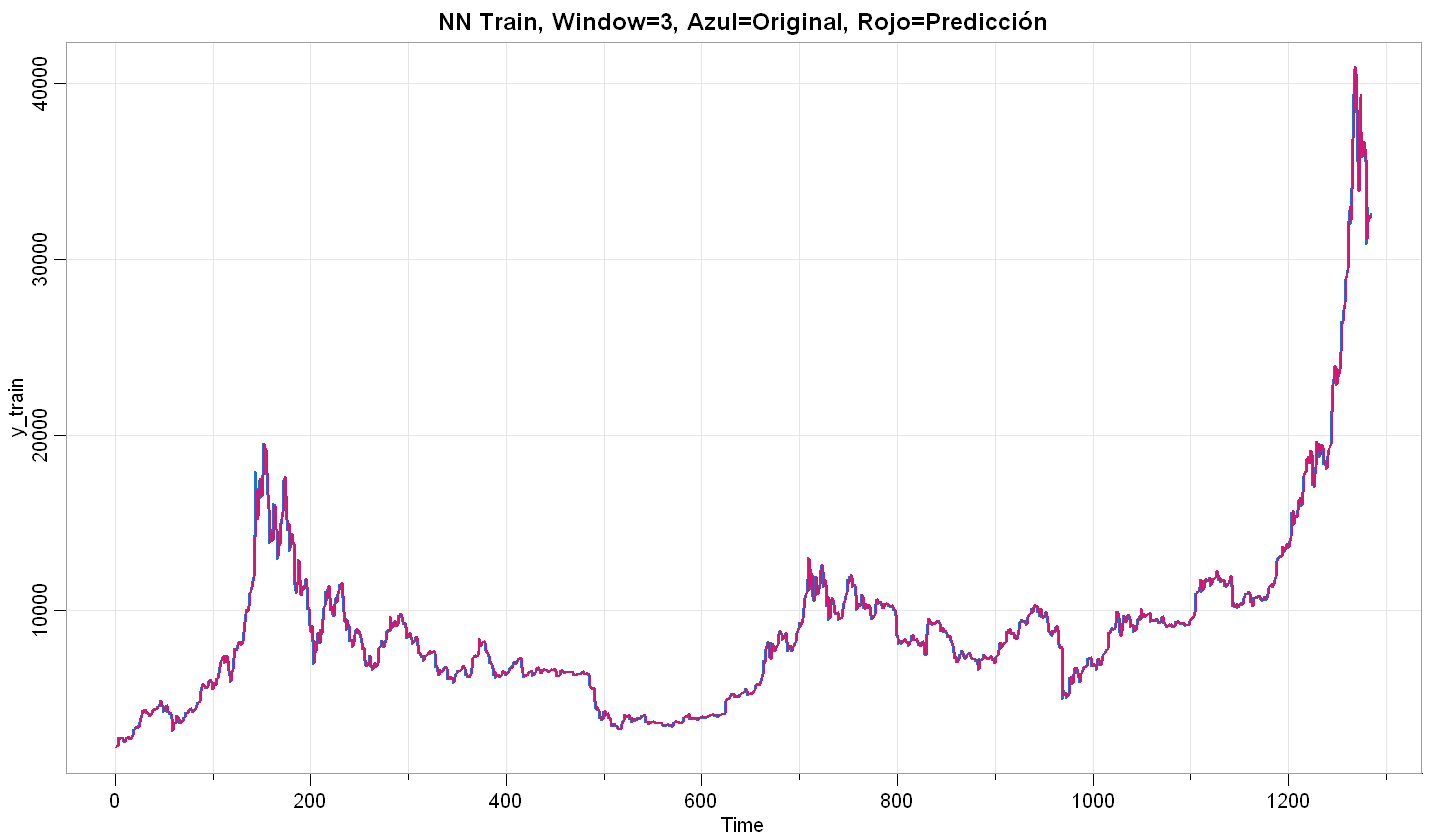

In [126]:
y1 <- predict(model1,X_train)

tsplot(y_train, col=4, lwd=2, main='NN Train, Window=3, Azul=Original, Rojo=Predicción')
axis(1, time(btc) ) # , format(dm$Date, "%b %d"), cex.axis = .7)
lines(y1, col=6, lwd=2)


In [127]:
evaluate(model1,X_train,y_train)

loss      mse 
239156.4 239156.4

Para los datos vistos, el resultado es bueno. Puede ser que exista overfitting aunque se tiene una red sencilla.

#### Gráficos de TEST

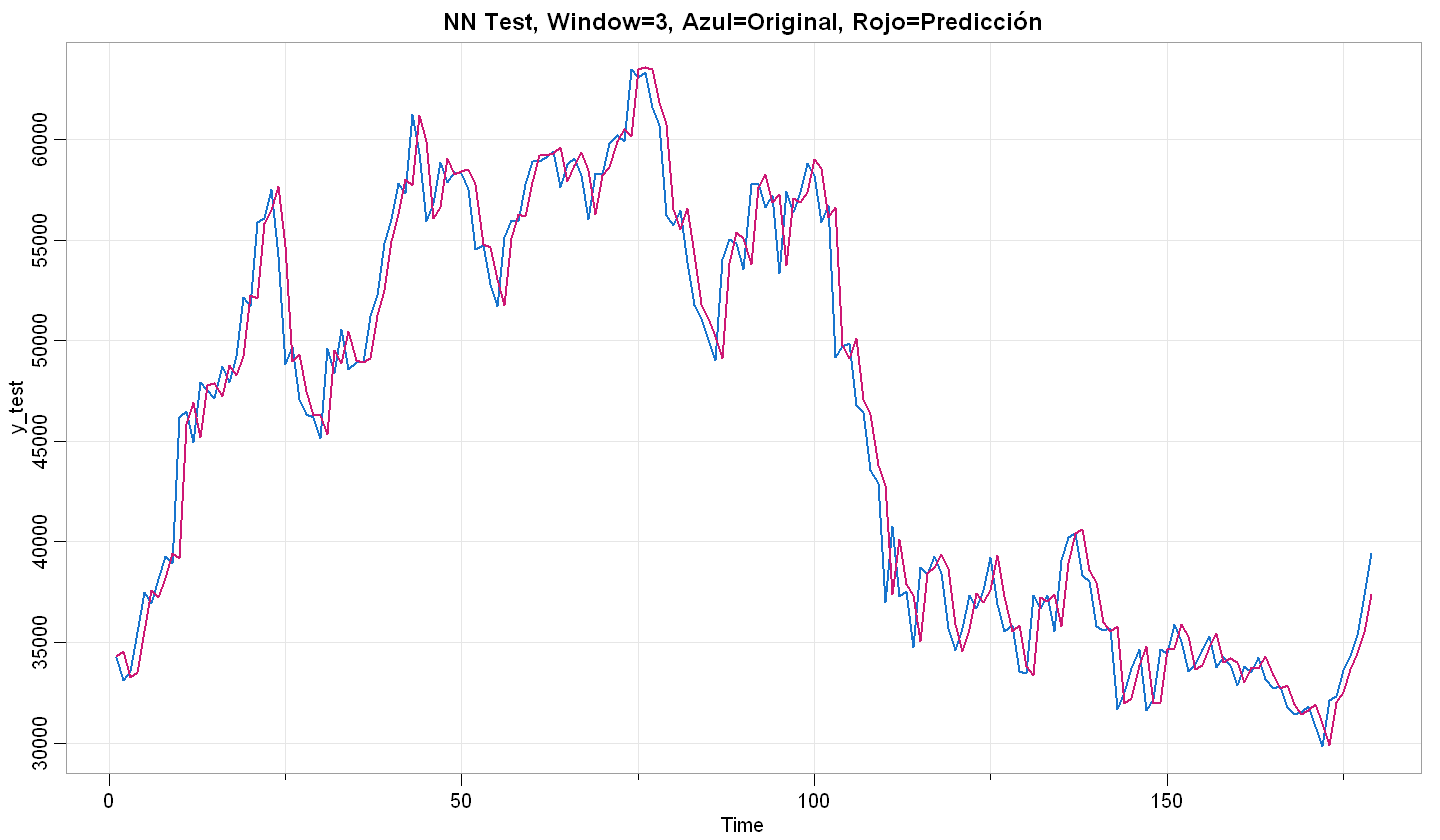

In [128]:
y1_test <- predict(model1,X_test)

tsplot(y_test, col=4, lwd=2, main='NN Test, Window=3, Azul=Original, Rojo=Predicción')
lines(y1_test, col=6, lwd=2)

In [129]:
evaluate(model1,X_test,y_test)

loss     mse 
4055160 4055160

Lo que se ve es que para test lo que 'predice' es la serie con un lag de un día.

### Red simple con ventana=20

In [130]:
split_train <- split_train_test(x,i_fecha=v_fecha, i_window=20)

X_train <- split_train$X_train
y_train <- split_train$y_train
X_test  <- split_train$X_test
y_test  <- split_train$y_test

[1] 1288


In [131]:
# initialize our model
model2 <- keras_model_sequential()

model2 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 64, activation="relu") %>%
    layer_dense(units = 1)

In [132]:
trained_model <- train_nn(model2, v_loss, v_optimizer, v_metrics, v_epochs, v_split)

In [133]:
model2         <- trained_model$model
trained_model2 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



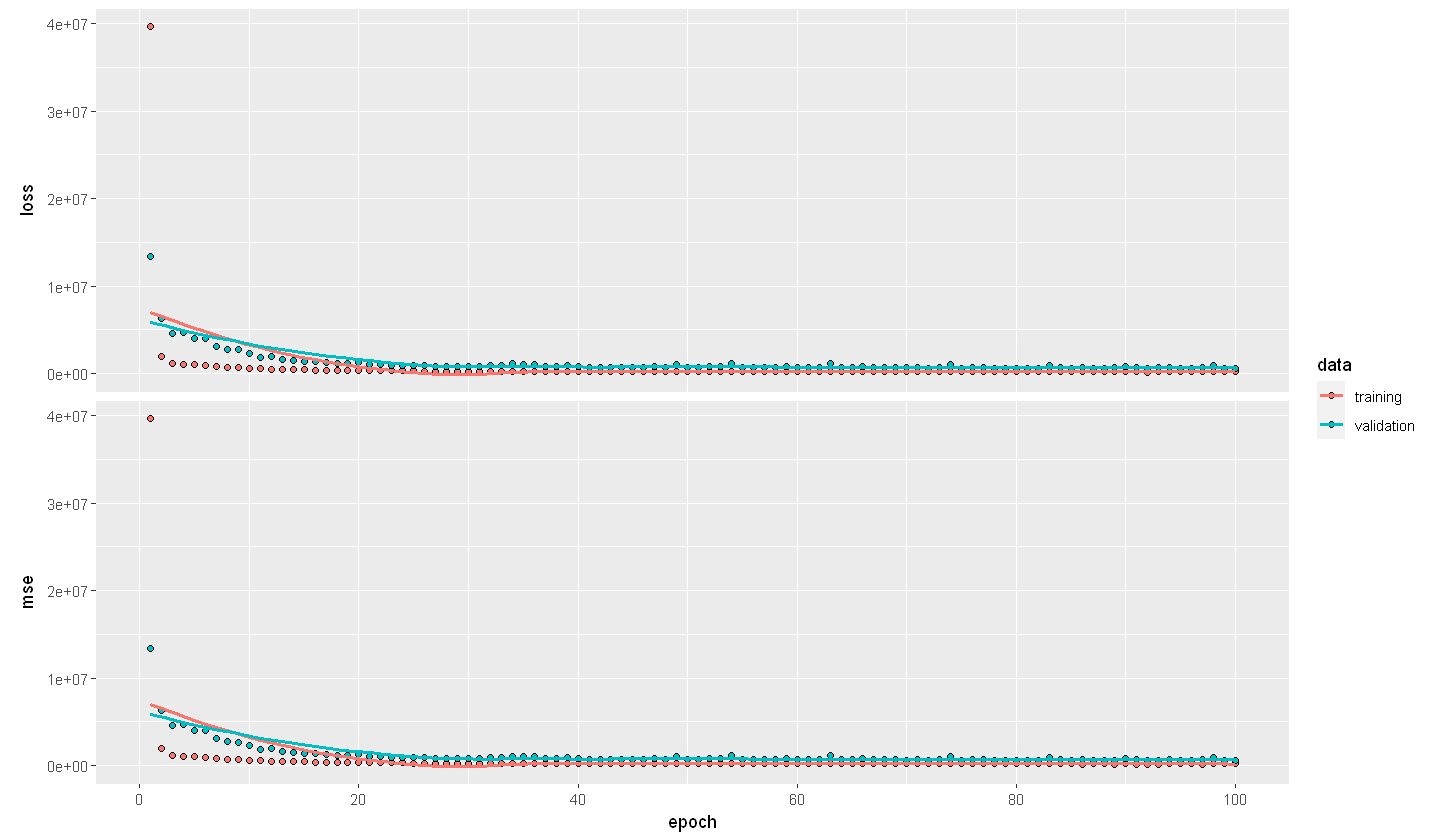

In [134]:
plot(trained_model2)

#### Gráficos de TRAIN

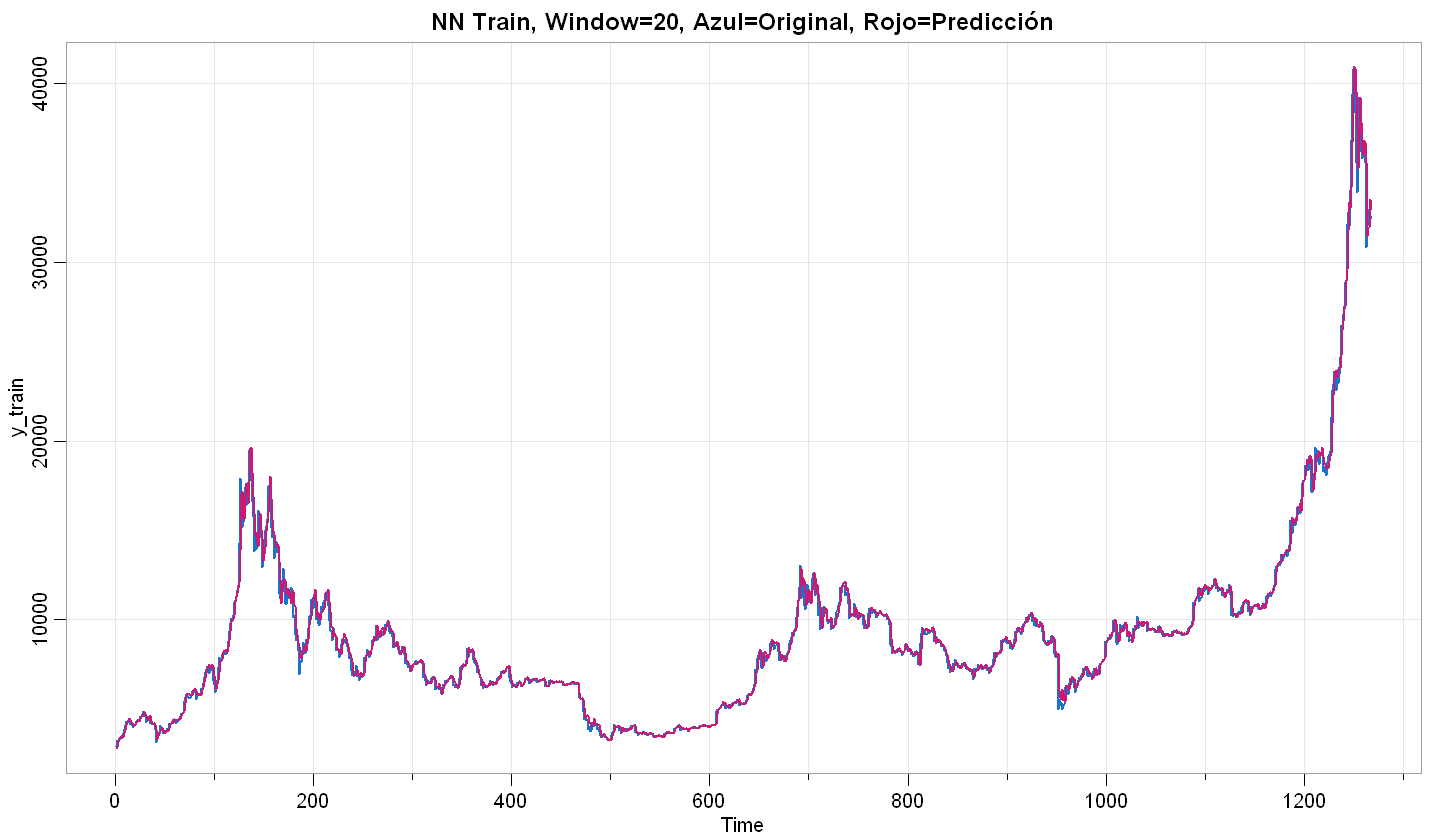

In [135]:
y2 <- predict(model2,X_train)

tsplot(y_train, col=4, lwd=2, main='NN Train, Window=20, Azul=Original, Rojo=Predicción')
lines(y2, col=6, lwd=2)

In [136]:
evaluate(model2,X_train,y_train)

loss      mse 
268441.8 268441.8

### Gráficos de TEST

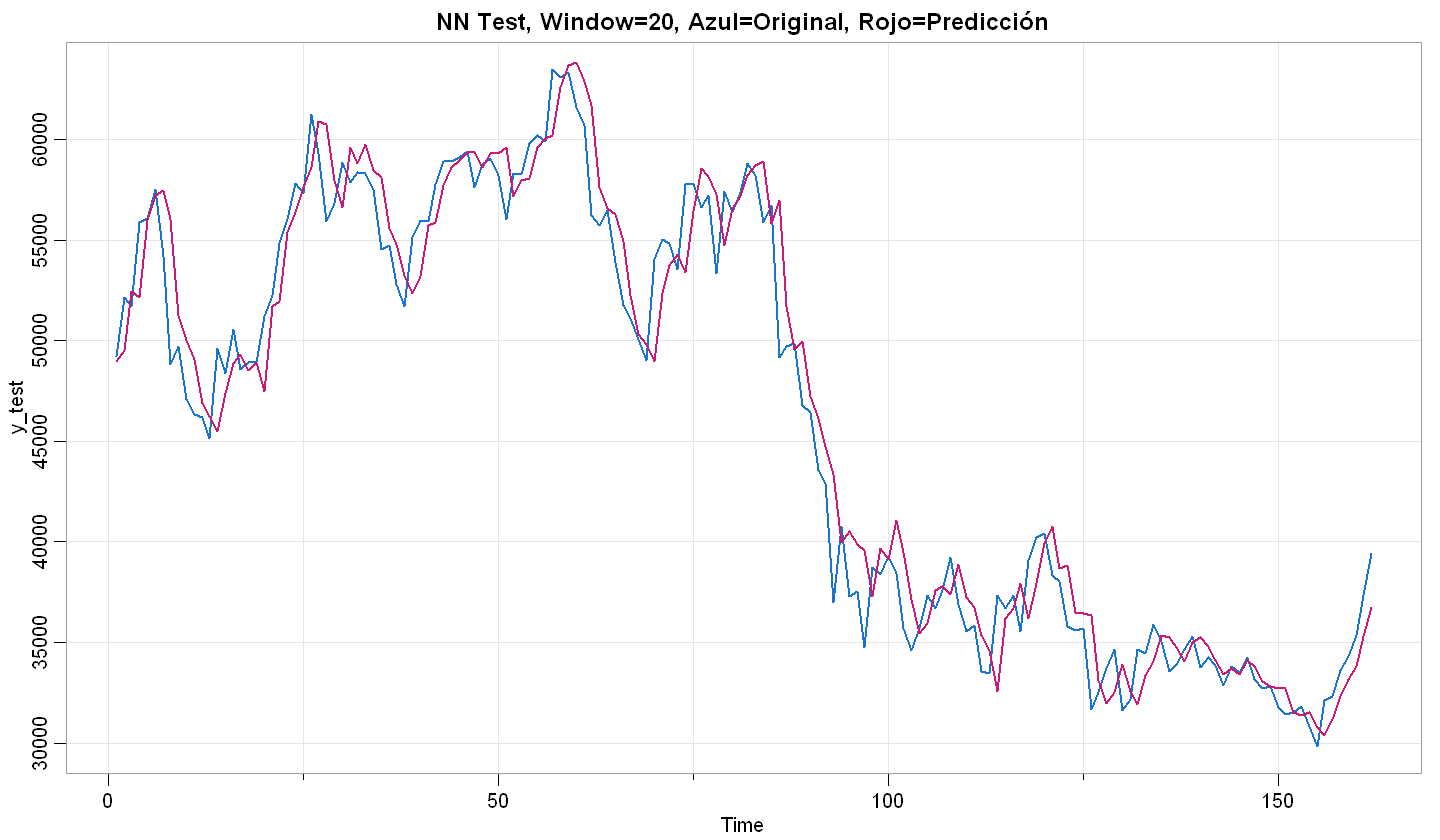

In [137]:
y2_test <- predict(model2,X_test)

tsplot(y_test, col=4, lwd=2,main='NN Test, Window=20, Azul=Original, Rojo=Predicción')
lines(y2_test, col=6, lwd=2)

In [138]:
evaluate(model2,X_test,y_test)

loss     mse 
4815115 4815115

El error con 20 días aumenta y sigue teniendo forma de la serie con diferencia de un día.

### Cálculo de Error si asumimos que el valor de hoy es igual de mañana

In [139]:
# La serie con lag de 1 día

p1 <- y_test[1:length(y_test)-1]
p2 <- y_test[2:length(y_test)]

In [140]:
calculate_mse(p1,p2)

[1] 4069739

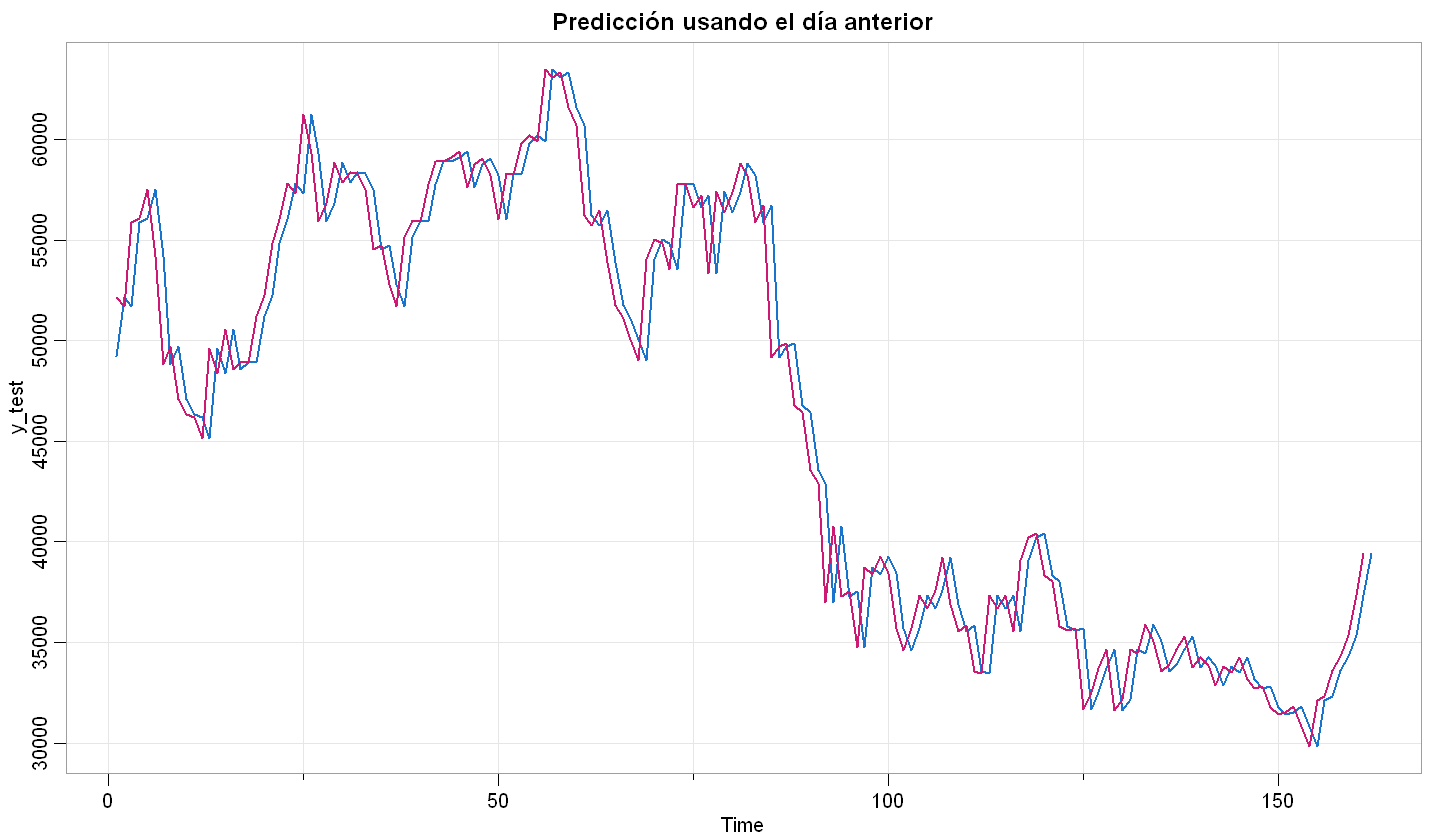

In [141]:
tsplot(y_test, col=4, lwd=2, main="Predicción usando el día anterior")
lines(p2, col=6, lwd=2)

Con esta red, resulta mejor predecir con el valor de ayer que hacer todo el entrenamiento.

### RNN NN

In [142]:
split_train <- split_train_test(x,i_fecha=v_fecha)

X_train <- split_train$X_train
y_train <- split_train$y_train
X_test  <- split_train$X_test
y_test  <- split_train$y_test

[1] 1288


In [143]:
# initialize our model
model3 <- keras_model_sequential()

model3 %>%
    #layer_simple_rnn(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_simple_rnn(input_shape = dim(X_train)[2:3], units = 64, activation="relu") %>%
    layer_dense(units = 1)

In [144]:
trained_model <- train_nn(model3, v_loss, v_optimizer, v_metrics, v_epochs, v_split)


In [145]:
model3         <- trained_model$model
trained_model3 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



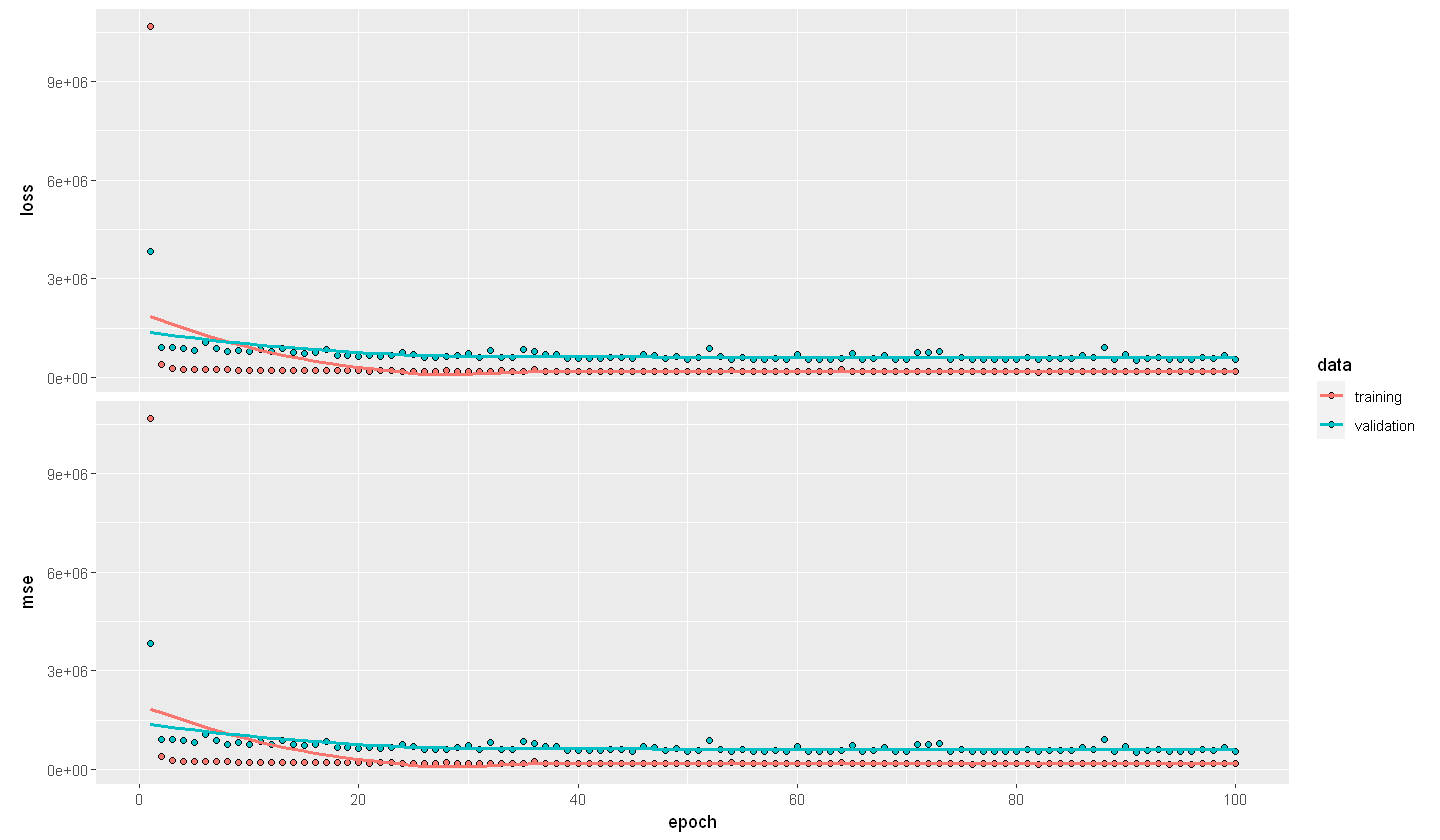

In [146]:
plot(trained_model3)

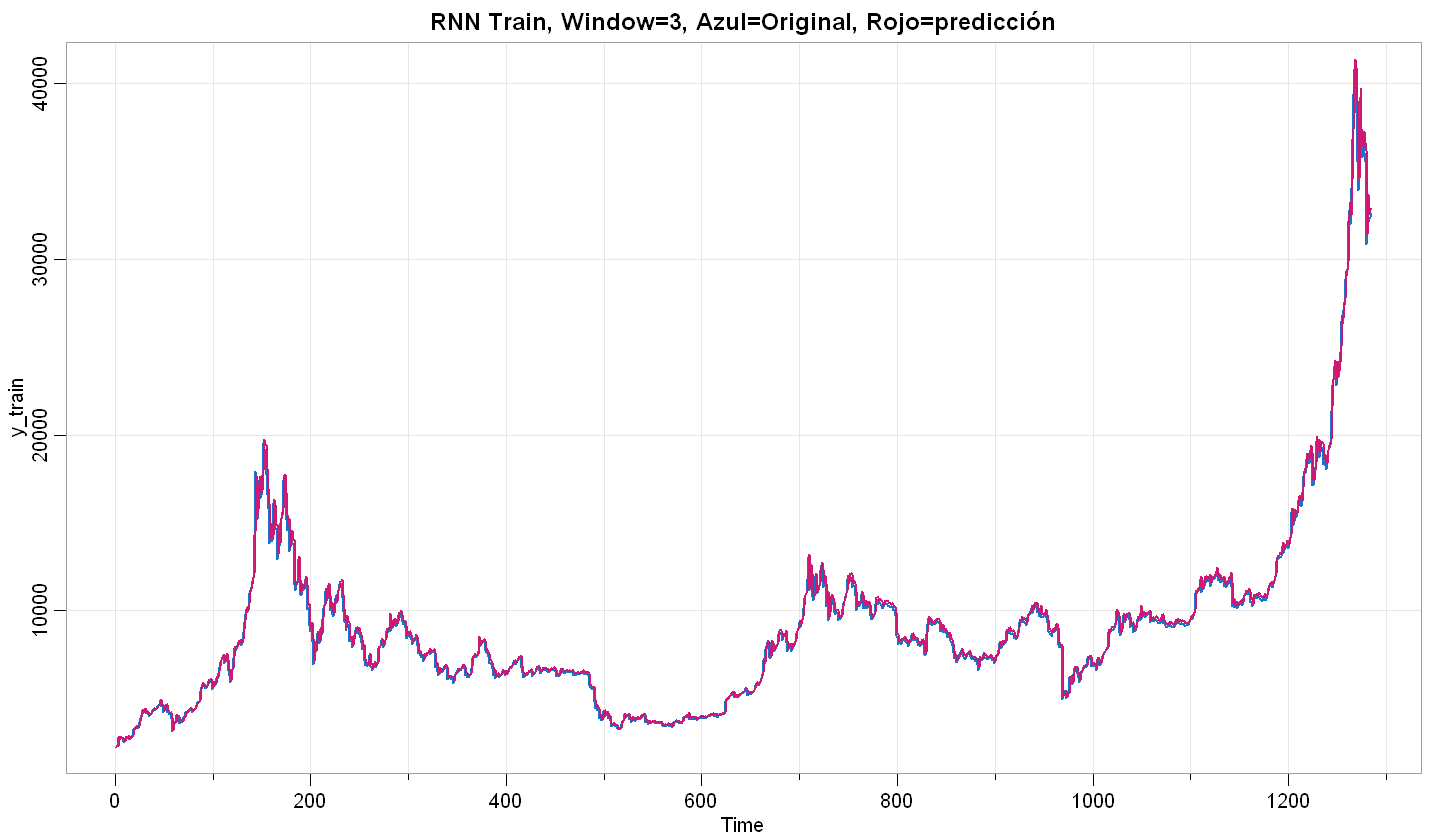

In [147]:
y3 = predict(model3,X_train)

tsplot(y_train, col=4, lwd=2, main="RNN Train, Window=3, Azul=Original, Rojo=predicción")
lines(y3, col=6, lwd=2)

In [148]:
evaluate(model3, X_train, y_train)


loss      mse 
255785.8 255785.8

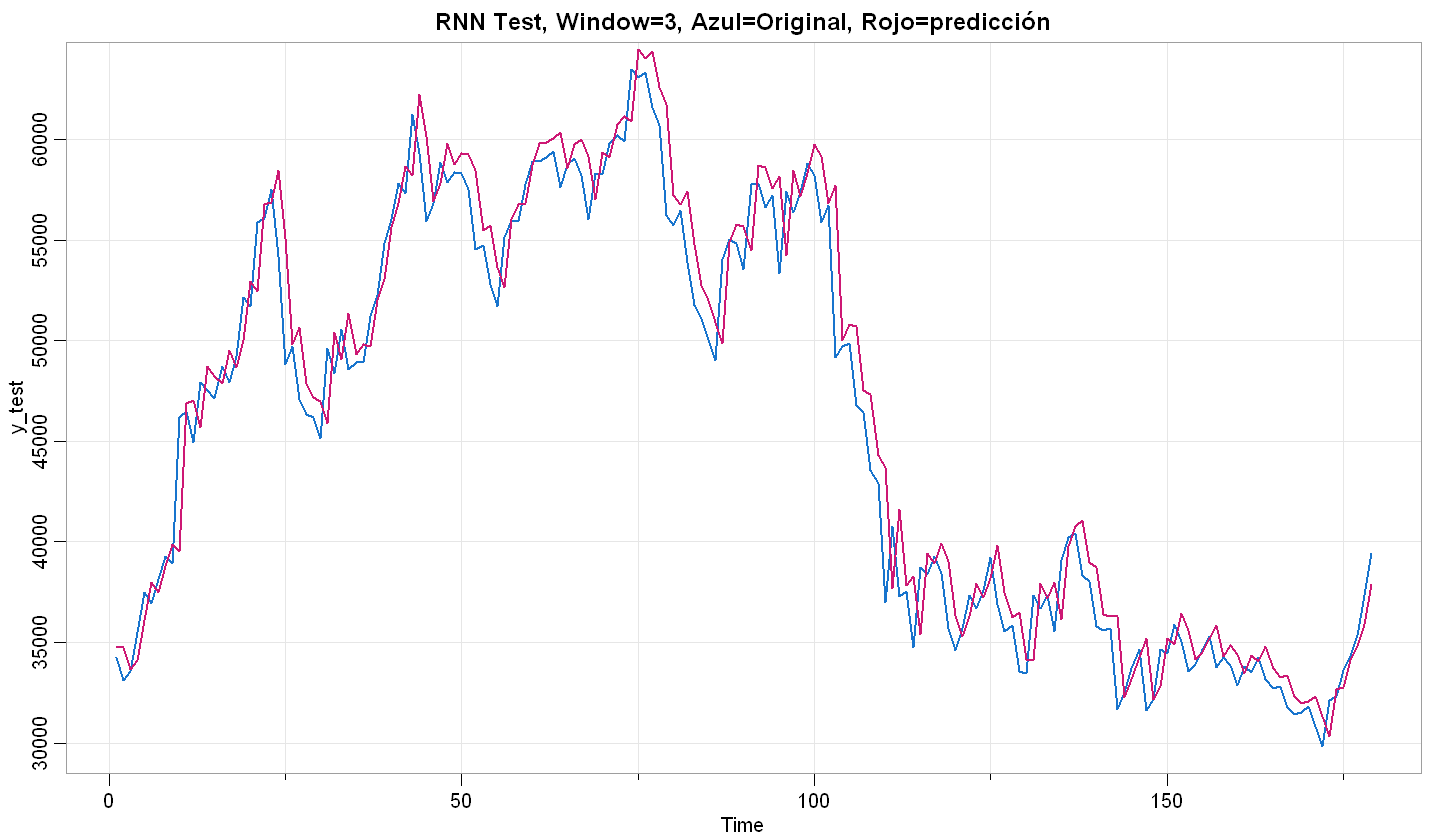

In [149]:
y3_test = predict(model3,X_test)

tsplot(y_test, col=4, lwd=2, main="RNN Test, Window=3, Azul=Original, Rojo=predicción")
lines(y3_test, col=6, lwd=2)

In [150]:
evaluate(model3, X_test, y_test)

loss     mse 
4767303 4767303

Se ve el mismo comportamiento que los anteriores.

### LSTM NN

In [151]:
# initialize our model
model4 <- keras_model_sequential()


model4 %>%
    layer_dense(input_shape = dim(X_train)[2:3], units = 8, activation = "relu") %>%
    layer_lstm(units = 64, activation="relu") %>%
    layer_dense(units = 64, activation="relu") %>%
    layer_dense(units = 1)

In [152]:
trained_model <- train_nn(model4, v_loss, v_optimizer, v_metrics, v_epochs, v_split)


In [153]:
model4         <- trained_model$model
trained_model4 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



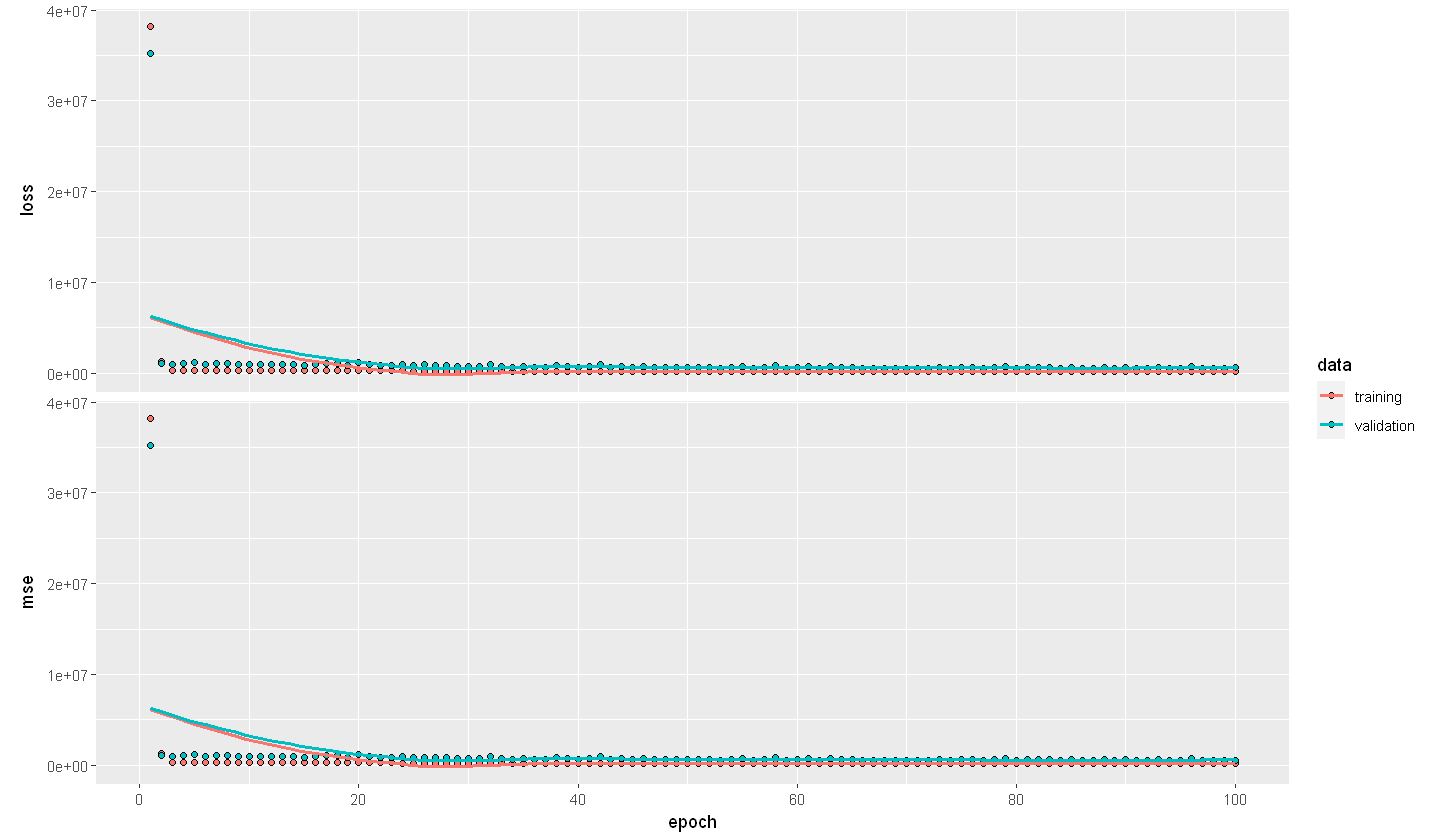

In [154]:
plot(trained_model4)

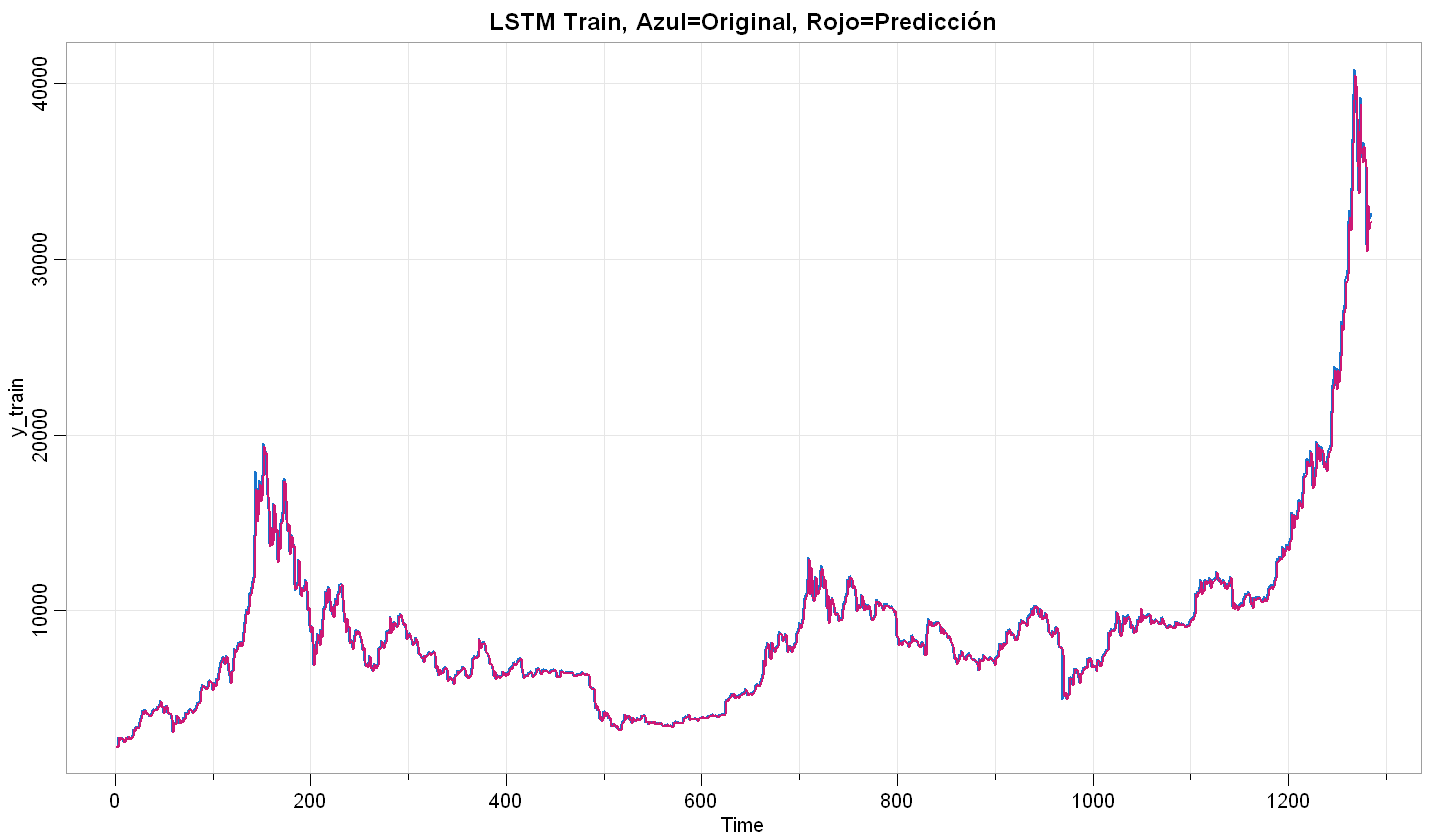

In [155]:
y4 = predict(model4,X_train)

tsplot(y_train, col=4, lwd=2, main='LSTM Train, Azul=Original, Rojo=Predicción')
lines(y4, col=6, lwd=2)

In [156]:
evaluate(model4, X_train, y_train)

loss      mse 
249389.9 249389.9

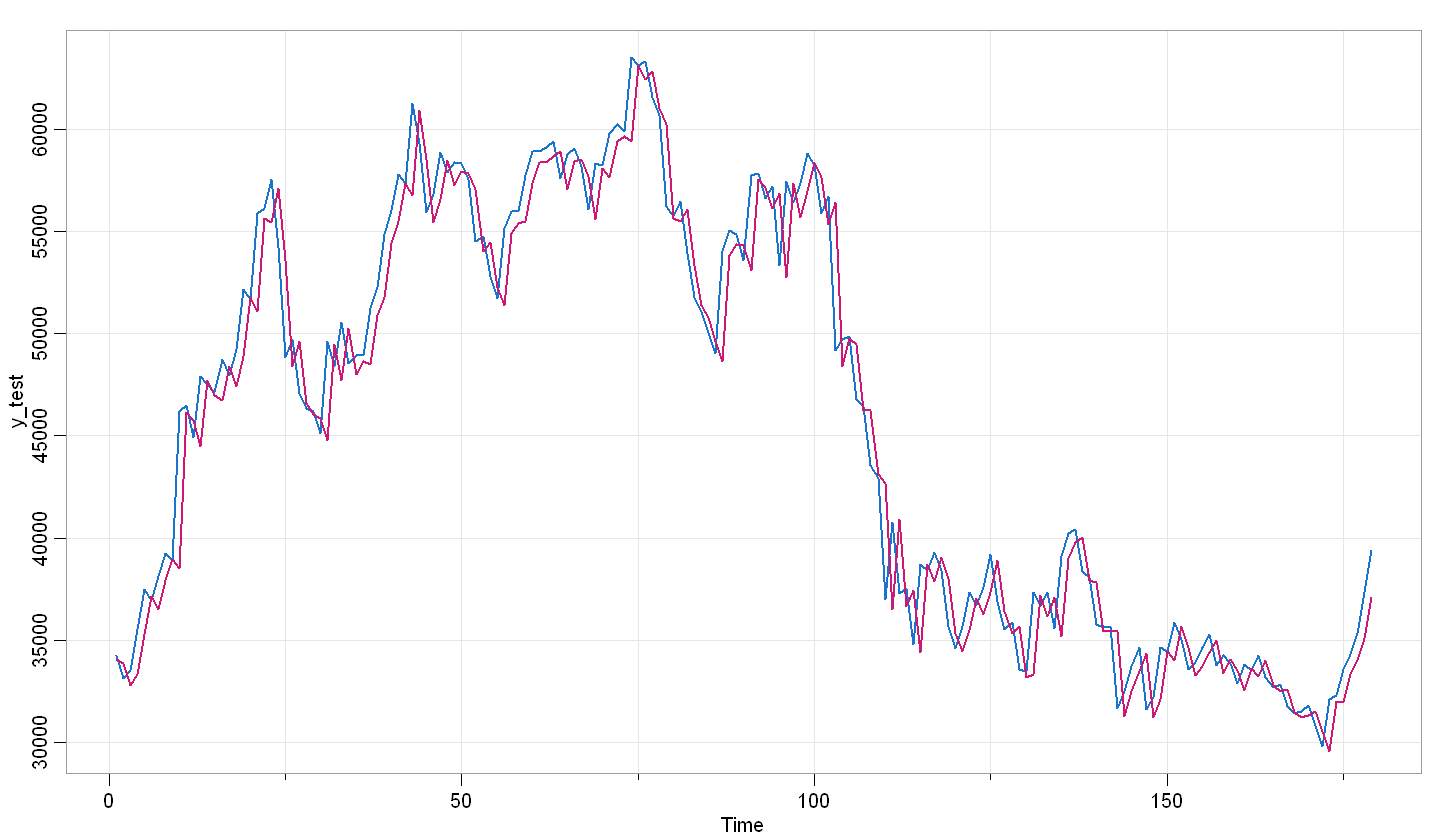

In [157]:
y4_test <- predict(model4,X_test, main='LSTM Test, Azul=Original, Rojo=Predicción')

tsplot(y_test, col=4, lwd=2)
lines(y4_test, col=6, lwd=2)

In [158]:
evaluate(model4,X_test,y_test)

loss     mse 
4352675 4352675

Al igual que las anteriores, la predicción para los datos no vistos es de la serie original con un lag de día.

### Predicción con otras series

In [159]:
#algo <- btc[time(btc)  %in%  c('2021-01-01','2021-01-02'),]
btc2 <- btc[time(aapl)]
eth2 <- eth[time(aapl)]
bnb2 <- bnb[time(aapl)]

In [160]:
v_colX <- c('aapl','tsla')
v_colY <- c('btc')

In [161]:
x2 <- na.omit( merge(aapl,tsla,eth2,bnb2,sp500,btc2) )

v_colnames2 <- c('aapl','tsla','eth','bnb','sp500','btc')
colnames(x2) <- v_colnames2


In [162]:
na_count <-sapply(x2, function(y) sum(length(which(is.na(y)))))


In [163]:
na_count

aapl  tsla   eth   bnb sp500   btc 
    0     0     0     0     0     0

In [164]:
x2_train <- x2[time(x2) < v_fecha, v_colX]
y2_train <- x2[time(x2) < v_fecha, v_colY]

x2_test <- x2[time(x2) >= v_fecha, v_colX]
y2_test <- x2[time(x2) >= v_fecha, v_colY]



In [165]:
X_train <- coredata(x2_train)
y_train <- coredata(y2_train)

X_test <- coredata(x2_test)
y_test <- coredata(y2_test)

X_train <- array(X_train, dim = c(dim(X_train))) 
X_test  <- array(X_test, dim = c(dim(X_test)))


In [166]:
# initialize our model
model5 <- keras_model_sequential()

model5 %>%
    layer_flatten(input_shape = ncol(X_train)) %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 1)

In [167]:
summary(model5)

Model: "sequential_10"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_6 (Flatten)                 (None, 2)                       0           
________________________________________________________________________________
dense_27 (Dense)                    (None, 256)                     768         
________________________________________________________________________________
dense_26 (Dense)                    (None, 256)                     65792       
________________________________________________________________________________
dense_25 (Dense)                    (None, 256)                     65792       
________________________________________________________________________________
dense_24 (Dense)                    (None, 1)                       257         
Total params: 132,609
Trainable params: 132,609
Non-trainable params: 0
______________

In [168]:
trained_model <- train_nn(model5, v_loss, v_optimizer, v_metrics, v_epochs, v_split)

In [169]:
model5         <- trained_model$model
trained_model5 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



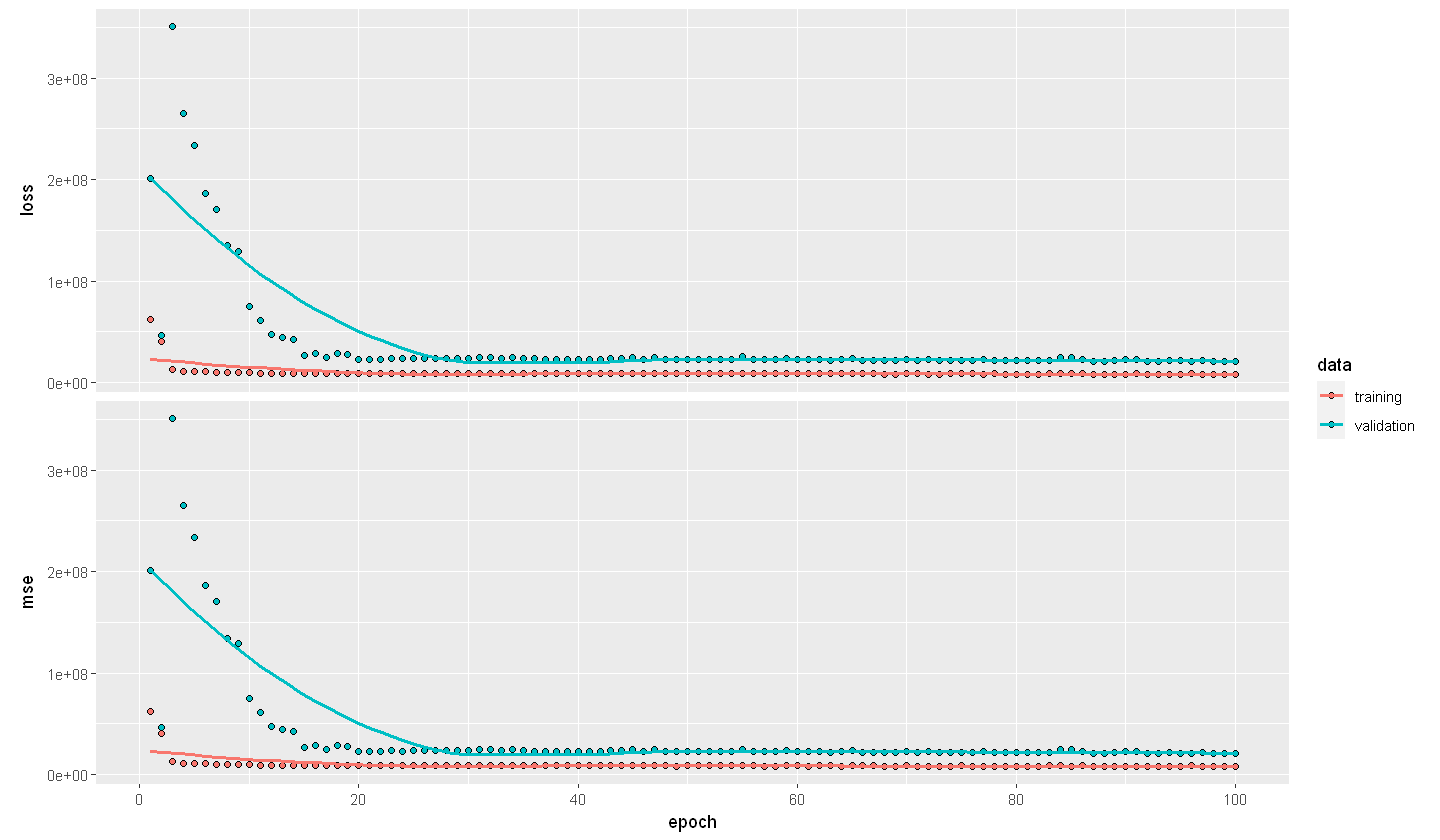

In [170]:
plot(trained_model5)

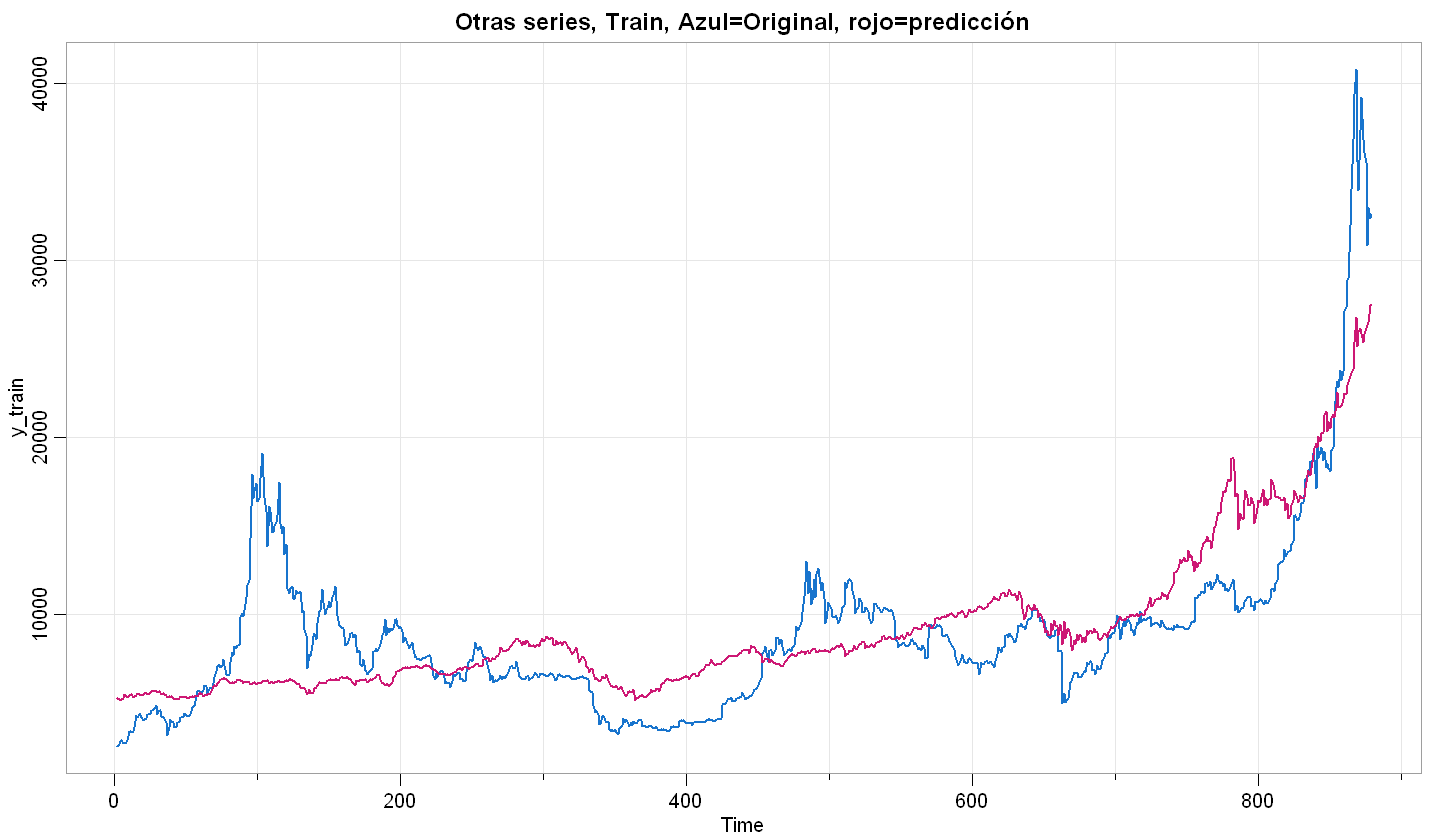

In [171]:
y5 <- predict(model5,X_train )

tsplot(y_train, col=4, lwd=2,main="Otras series, Train, Azul=Original, rojo=predicción")
lines(y5, col=6, lwd=2)

In [172]:
evaluate(model5, X_train, y_train)

loss      mse 
10641712 10641712

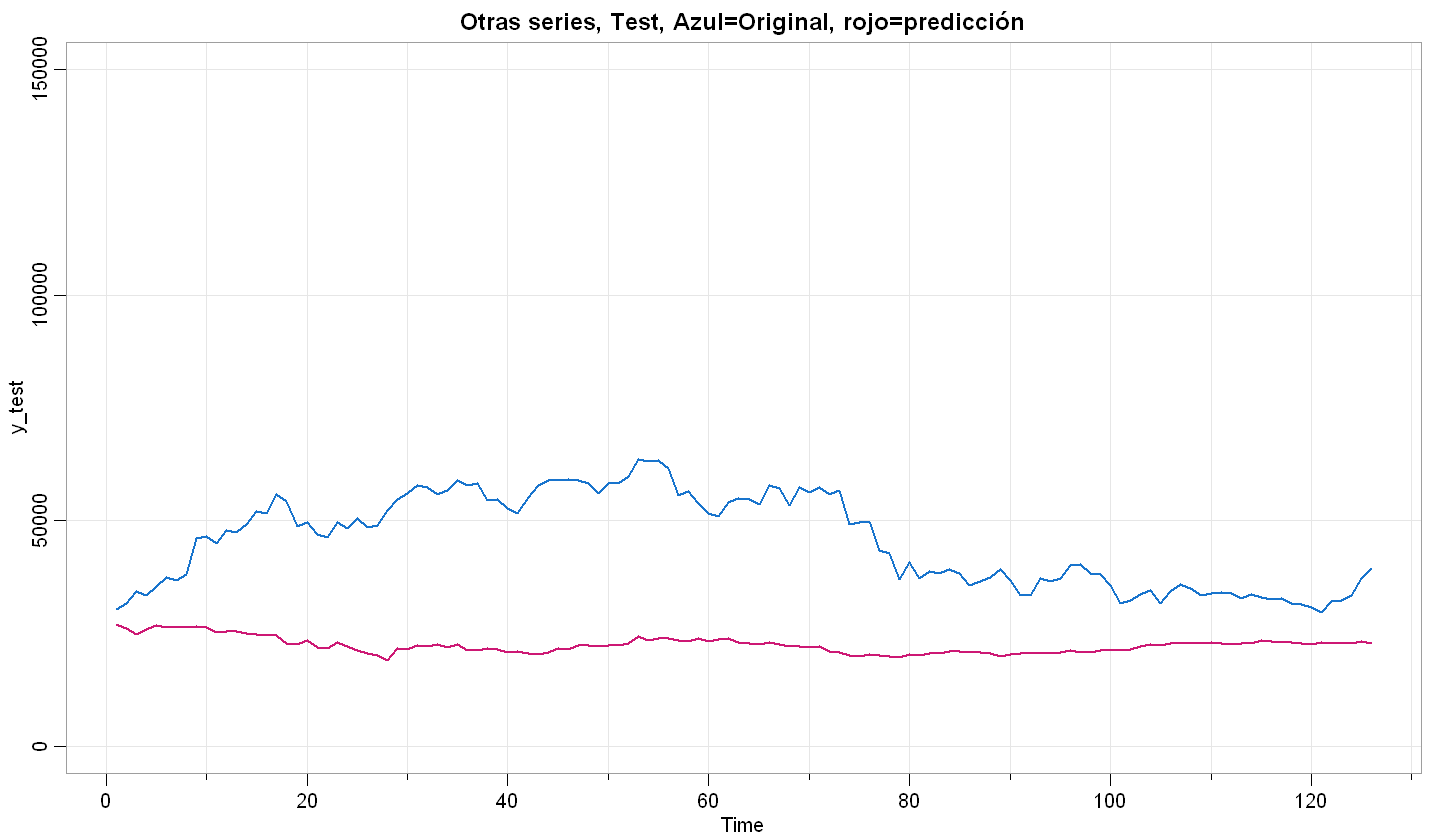

In [173]:
y5_test <- predict(model5,X_test)

tsplot(y_test, col=4, lwd=2, ylim=c(0,150000),main="Otras series, Test, Azul=Original, rojo=predicción")
lines(y5_test, col=6, lwd=2)

In [174]:
evaluate(model5, X_test, y_test)

loss       mse 
643910912 643910912

### Modelo con 5 series predictores

In [175]:
v_colX <- c('aapl','tsla','eth','bnb','sp500')
v_colY <- c('btc')

In [176]:
x2 <- na.omit( merge(aapl,tsla,eth2,bnb2,sp500,btc2) )

v_colnames2 <- c('aapl','tsla','eth','bnb','sp500','btc')
colnames(x2) <- v_colnames2

In [177]:
x2_train <- x2[time(x2) < v_fecha, v_colX]
y2_train <- x2[time(x2) < v_fecha, v_colY]

x2_test <- x2[time(x2) >= v_fecha, v_colX]
y2_test <- x2[time(x2) >= v_fecha, v_colY]



In [178]:
X_train <- coredata(x2_train)
y_train <- coredata(y2_train)

X_test <- coredata(x2_test)
y_test <- coredata(y2_test)

X_train <- array(X_train, dim = c(dim(X_train))) 
X_test  <- array(X_test, dim = c(dim(X_test)))

In [179]:
# initialize our model
model6 <- keras_model_sequential()

model6 %>%
    layer_flatten(input_shape = ncol(X_train)) %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 1)

In [180]:
summary(model6)

Model: "sequential_11"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_7 (Flatten)                 (None, 5)                       0           
________________________________________________________________________________
dense_31 (Dense)                    (None, 256)                     1536        
________________________________________________________________________________
dense_30 (Dense)                    (None, 256)                     65792       
________________________________________________________________________________
dense_29 (Dense)                    (None, 256)                     65792       
________________________________________________________________________________
dense_28 (Dense)                    (None, 1)                       257         
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
______________

In [181]:
trained_model <- train_nn(model6, v_loss, v_optimizer, v_metrics, v_epochs, v_split)

In [182]:
model6         <- trained_model$model
trained_model6 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



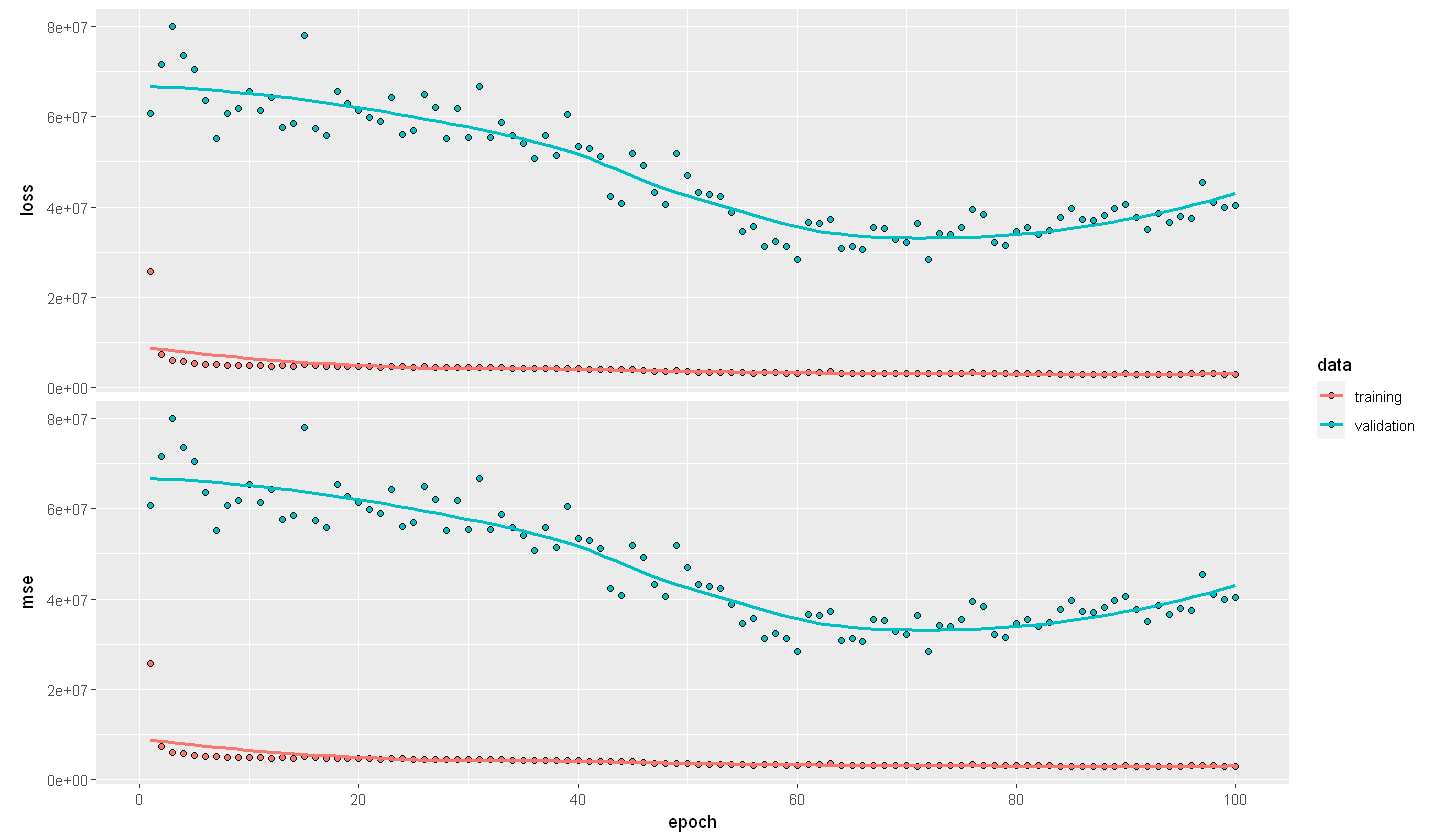

In [183]:
plot(trained_model6)

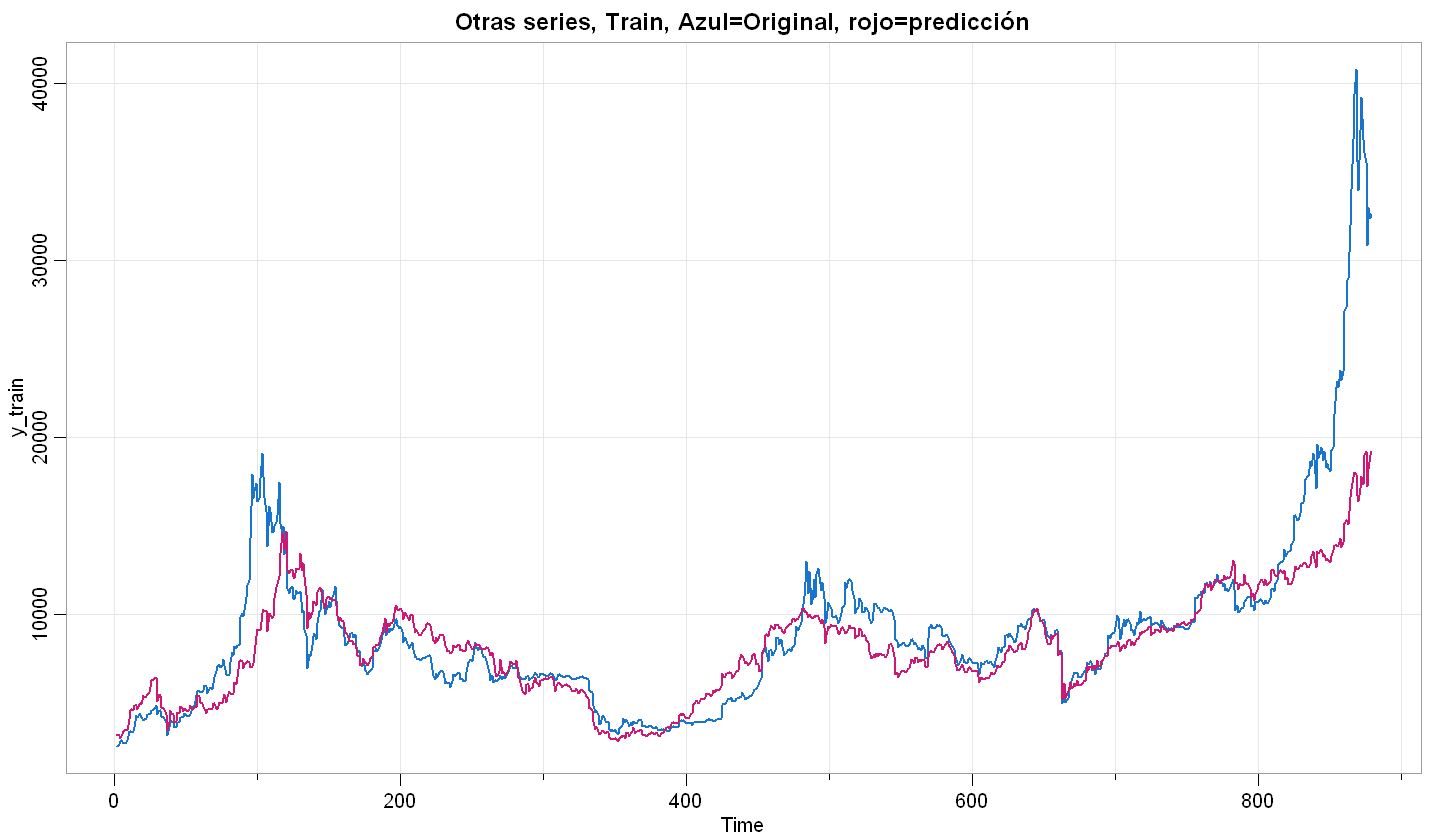

In [184]:
y6 <- predict(model6,X_train )

tsplot(y_train, col=4, lwd=2,main="Otras series, Train, Azul=Original, rojo=predicción")
lines(y6, col=6, lwd=2)

In [185]:
evaluate(model6, X_train, y_train)

loss      mse 
10331508 10331508

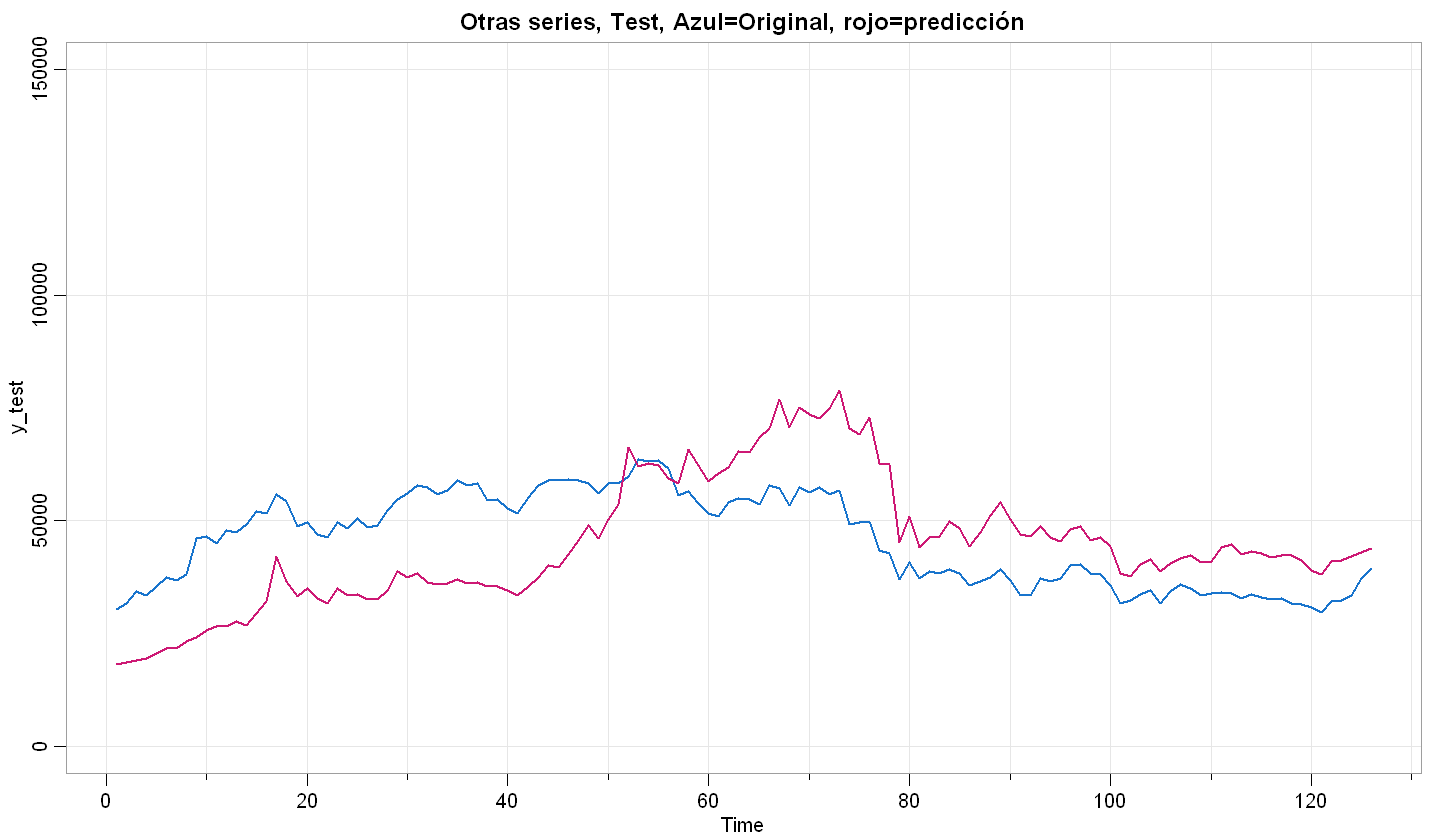

In [186]:
y6_test <- predict(model6,X_test)

tsplot(y_test, col=4, lwd=2, ylim=c(0,150000),main="Otras series, Test, Azul=Original, rojo=predicción")
lines(y6_test, col=6, lwd=2)

In [187]:
evaluate(model6, X_test, y_test)

loss       mse 
197515312 197515312

Con 5 series mejora respecto a 2 pero sigue teniendo más error que la predicción simple del día antes.

# Prueba inconclusas

### GRU NN

In [77]:
split_train <- split_train_test(x,i_fecha=v_fecha)

X_train <- split_train$X_train
y_train <- split_train$y_train
X_test  <- split_train$X_test
y_test  <- split_train$y_test

[1] 1993


In [78]:
head(X_train)

, , 1

        [,1]    [,2]    [,3]
[1,] 285.829 278.089 279.472
[2,] 278.089 279.472 274.901
[3,] 279.472 274.901 273.614
[4,] 274.901 273.614 278.981
[5,] 273.614 278.981 275.833
[6,] 278.981 275.833 277.222

In [79]:
# initialize our model
model6 <- keras_model_sequential()

model6 %>%
    layer_dense(input_shape = dim(X_train)[2:3], units = 128, activation = "relu") %>%
    layer_gru(units = 128, activation="tanh") %>%
    layer_dense(units = 1)

In [80]:
summary(model6)

Model: "sequential_5"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_13 (Dense)                    (None, 3, 128)                  256         
________________________________________________________________________________
gru (GRU)                           (None, 128)                     98688       
________________________________________________________________________________
dense_12 (Dense)                    (None, 1)                       129         
Total params: 99,073
Trainable params: 99,073
Non-trainable params: 0
________________________________________________________________________________


In [81]:
model6 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [82]:
trained_model6 <- model6 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 50, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


`geom_smooth()` using formula 'y ~ x'



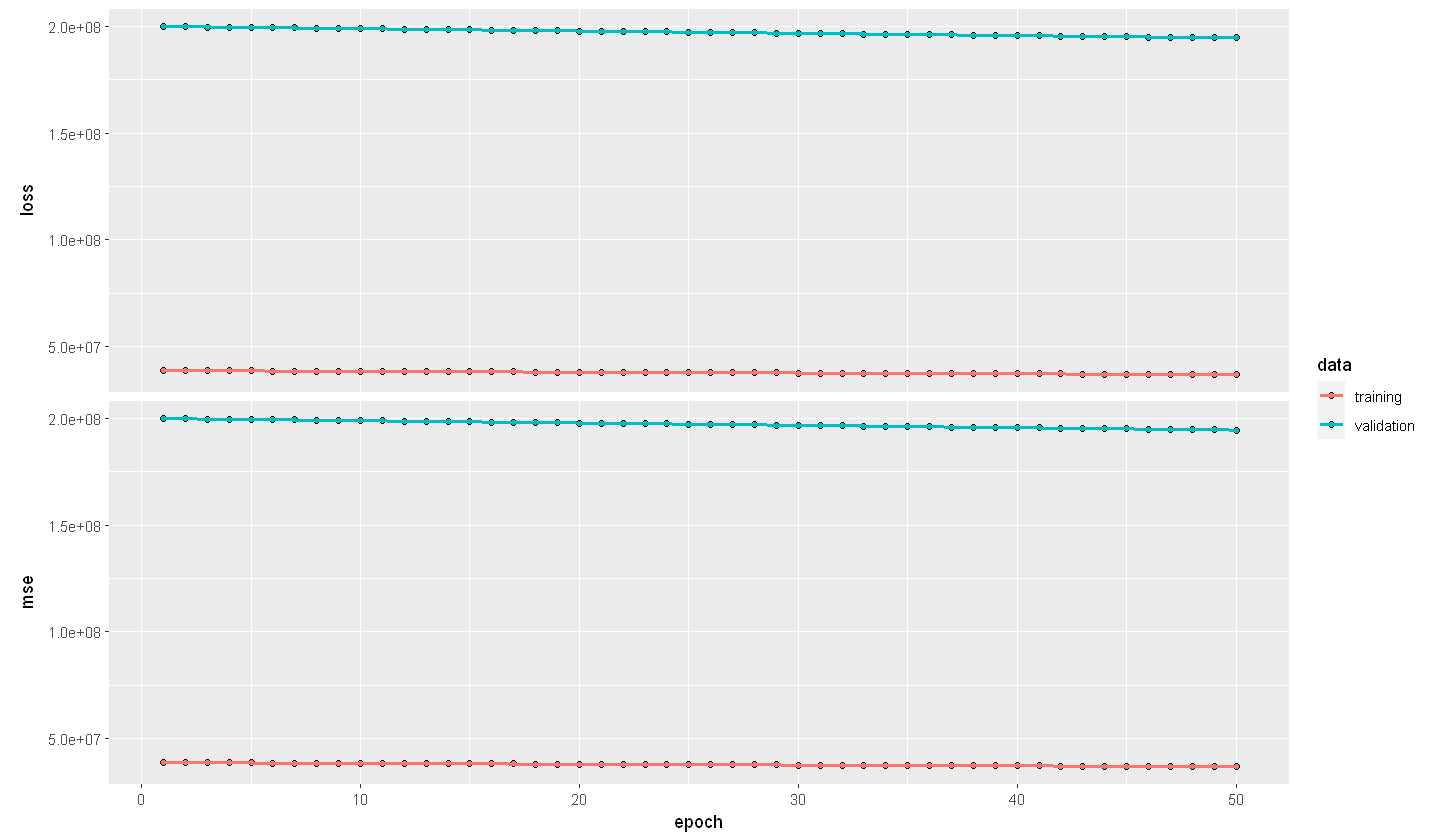

In [83]:
plot(trained_model6)

In [84]:
evaluate(model6, X_train, y_train)

loss      mse 
52534300 52534300

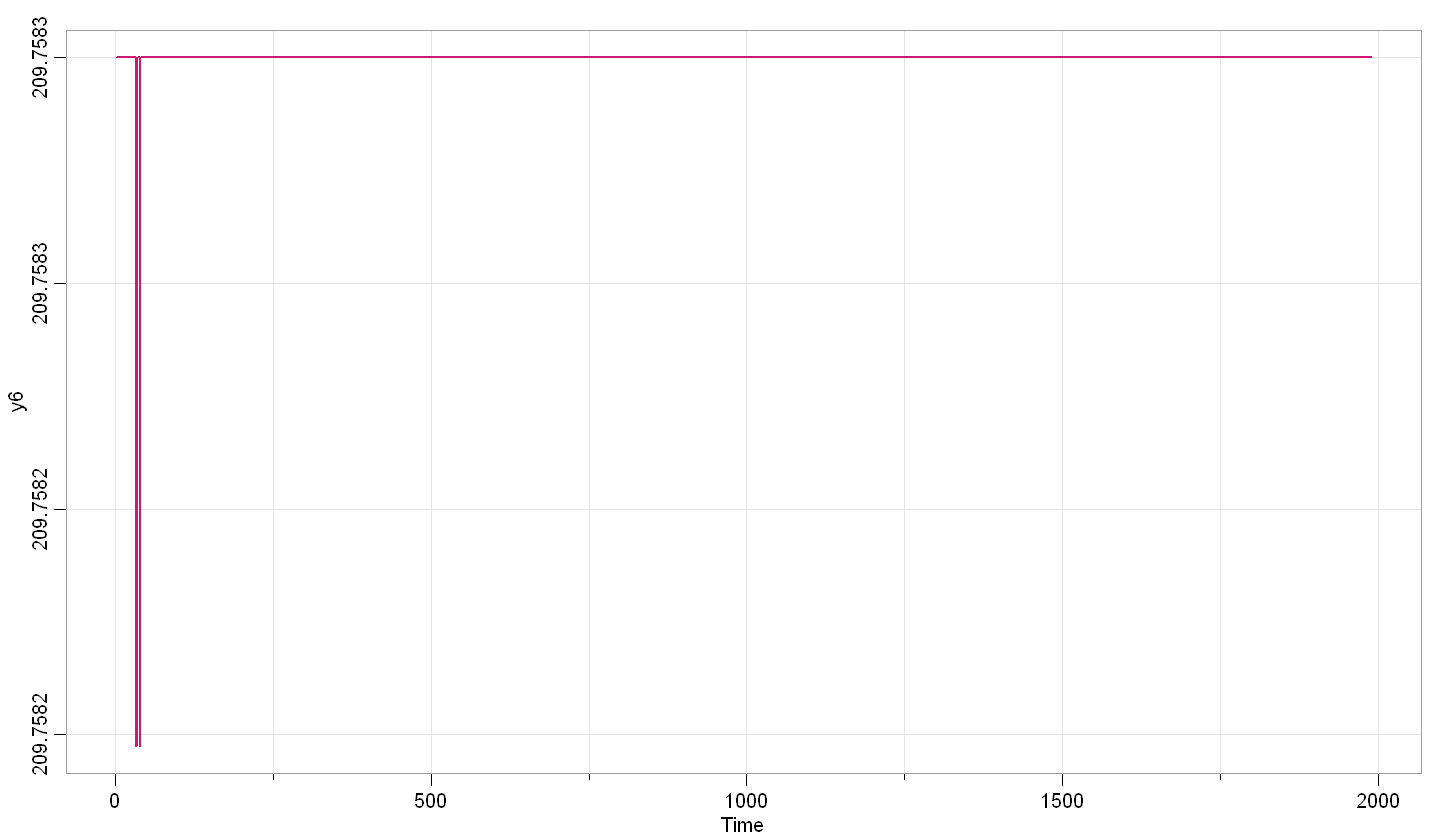

In [85]:
y6 <- predict(model6,X_train)

tsplot(y6, col=4, lwd=2)
lines(y6, col=6, lwd=2)

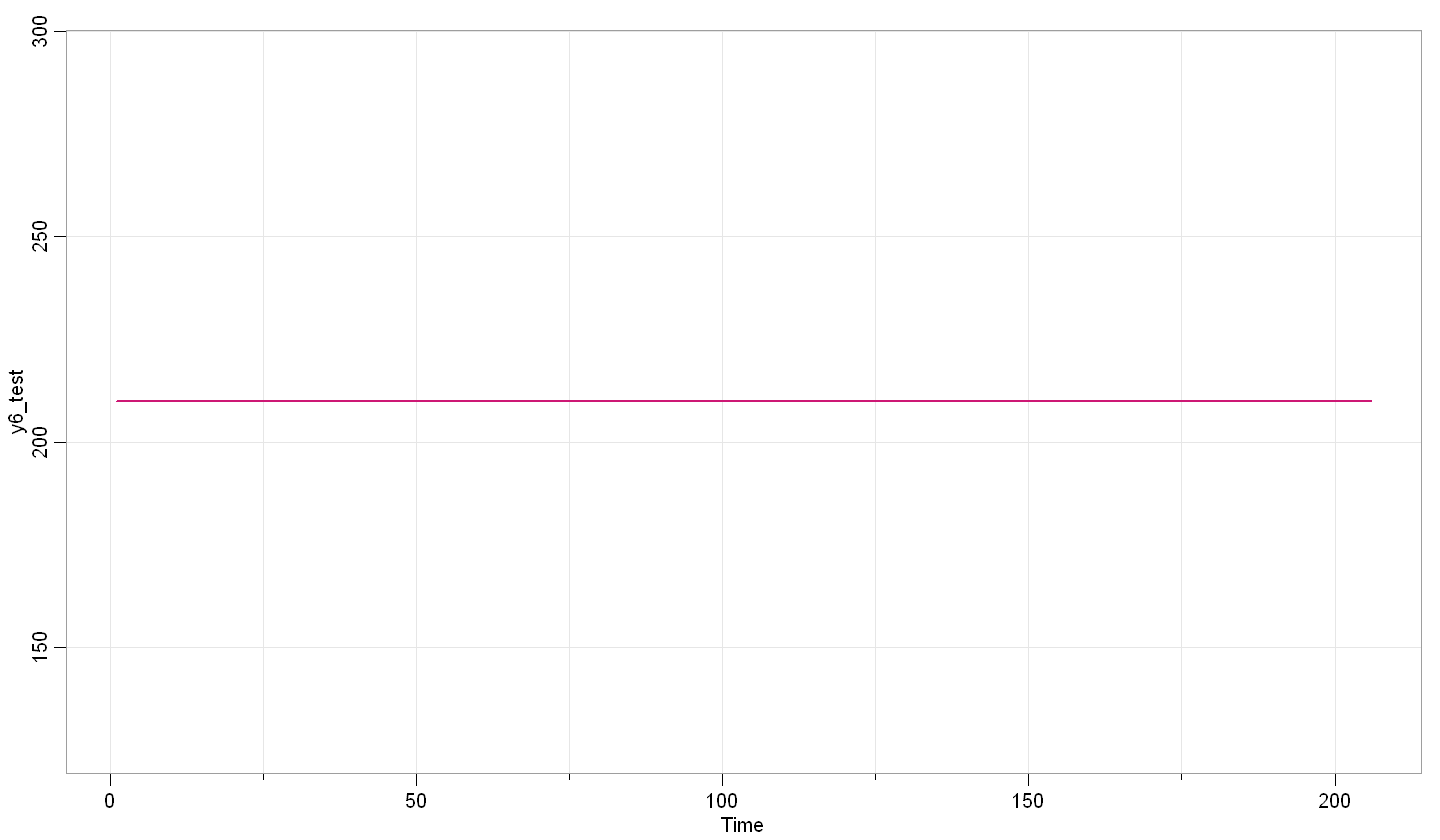

In [86]:
y6_test <- predict(model6,X_test)

tsplot(y6_test, col=4, lwd=2)
lines(y6_test, col=6, lwd=2)

In [87]:
evaluate(model6, X_test, y_test)

loss        mse 
2061436928 2061436928